# Trabajo Práctico 2: Gradiente Descendente

## Alumnos:
###   - Luca Mazzarello
###   - Ignacio Pardo

## Importación de Librerías

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import itertools
import seaborn as sns
from IPython.display import display, Markdown

In [9]:
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

In [10]:
# Display loss with all digits (not rounded)

pd.options.display.float_format = '{:,.20f}'.format

In [65]:
np.random.seed(42)

## Lectura de Datos

In [197]:
real_estate: pd.DataFrame = pd.read_excel('data/Real estate valuation data set.xlsx')
real_estate.drop(['No'], axis=1, inplace=True)

short = real_estate.copy()
short.columns = short.columns.map(lambda x: x.split(' ')[0])
display(short.head())

X1                      X2                       X3  \
0 2,012.91666669999995065155 32.00000000000000000000  84.87882000000000459750   
1 2,012.91666669999995065155 19.50000000000000000000 306.59469999999998890416   
2 2,013.58333330000004934845 13.30000000000000071054 561.98450000000002546585   
3 2,013.50000000000000000000 13.30000000000000071054 561.98450000000002546585   
4 2,012.83333330000004934845  5.00000000000000000000 390.56839999999999690772   

   X4                      X5                       X6                       Y  
0  10 24.98298000000000129717 121.54023999999999716692 37.89999999999999857891  
1   9 24.98034000000000176556 121.53951000000000703949 42.20000000000000284217  
2   5 24.98745999999999867214 121.54390999999999678494 47.29999999999999715783  
3   5 24.98745999999999867214 121.54390999999999678494 54.79999999999999715783  
4   5 24.97936999999999940769 121.54245000000000231921 43.10000000000000142109

In [198]:
#Normalize data
real_estate_ = (real_estate - real_estate.mean()) / real_estate.std()

X_matrix: np.ndarray = np.array(real_estate_.drop(['Y house price of unit area'], axis=1))
y_matrix: np.ndarray = np.array(real_estate_['Y house price of unit area']).reshape(-1, 1)

X_train: np.ndarray = X_matrix[0:315]
y_train: np.ndarray = y_matrix[0:315]

X_test: np.ndarray = X_matrix[315:]
y_test: np.ndarray = y_matrix[315:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((315, 6), (315, 1), (99, 6), (99, 1))

## Definición de clase NeuralNet

In [13]:
from typing import List, Tuple, Callable
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
import networkx as nx


class NeuralNet:
    def __init__(self):
        """
        Inicializa los parámetros de la red neuronal.
        2 capas con 5 neuronas cada una.
        """

        self.W1: ndarray = np.random.random((5, 6))
        self.b1: ndarray = np.random.random((5, 1))

        self.W2: ndarray = np.random.random((1, 5))
        self.b2: ndarray = np.random.random((1, 1))

        self.training_loss_acum: List[float] = []
        self.testing_loss_acum: List[float] = []

        self.activation = self.sigmoid

    def sigmoid(self, x: ndarray) -> ndarray:
        """
        Función de activación sigmoide.
        """
        return 1 / (1 + np.exp(-x))

    def relu(self, x: ndarray) -> ndarray:
        """
        Función de activación ReLU.
        """
        return np.maximum(0, x)

    def leaky_relu(self, x: ndarray) -> ndarray:
        """
        Función de activación Leaky ReLU.
        """
        return np.maximum(0.01 * x, x)

    def tanh(self, x: ndarray) -> ndarray:
        """
        Función de activación tanh.
        """
        return np.tanh(x)

    def softmax(self, x: ndarray) -> ndarray:
        """
        Función de activación softmax.
        """
        return np.exp(x) / np.sum(np.exp(x))

    def forward(
            self,
            x: ndarray,
            dropout: bool = False,
        ) -> ndarray:
        """
        Calcula la salida de la red neuronal.
        """

        self.z1 = self.W1 @ x.T + self.b1.repeat(x.shape[0], axis=1)
        self.a1 = self.activation(self.z1)

        # if dropout:
        #    self.a1 = self.dropout(self.a1, 0.5)

        self.z2 = self.W2 @ self.a1 + self.b2.repeat(self.a1.shape[1], axis=1)
        self.a2 = self.z2
        return self.a2.reshape(-1, 1)

    def numerical_gradient(
        self, x: ndarray, y: ndarray, eps: float, dropout: bool = False,
        dropout_prob: float = 0.5
    ) -> Tuple[ndarray, ndarray, ndarray, ndarray]:
        """
        Una estrategia para calcular estas derivadas parciales,
        consiste en calcular el promedio de los cocientes incrementales
        a derecha e izquierda.
        Para obtener la siguiente aproximación, para
        cada parámetro de la red calculamos:

        $$
        \frac{\partial L}{\partial p} \sim \frac{L(\theta_t, p + \epsilon) - L(\theta_t, p - \epsilon)}{2 \epsilon}
        $$

        donde usamos $p$ de forma genérica para referirnos a cada elemento $w^1_{i,j}$, $b^1_{j}$, $w^2_{i,j}$, $b^2_{j}$
        """

        dW1 = np.zeros_like(self.W1)
        db1 = np.zeros_like(self.b1)
        dW2 = np.zeros_like(self.W2)
        db2 = np.zeros_like(self.b2)

        if dropout:
            temp_w1 = self.W1.copy()
            self.W1 = self.dropout(self.W1, dropout_prob)
            temp_b1 = self.b1.copy()
            self.b1 = self.dropout(self.b1, dropout_prob)
            temp_w2 = self.W2.copy()
            self.W2 = self.dropout(self.W2, dropout_prob)
            temp_b2 = self.b2.copy()
            self.b2 = self.dropout(self.b2, dropout_prob)

        for i in range(self.W1.shape[0]):
            for j in range(self.W1.shape[1]):
                if dropout:
                    if self.W1[i, j] == 0 and temp_w1[i, j] != 0:
                        continue
                self.W1[i, j] += eps
                loss1 = self.loss(x, y)
                self.W1[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                dW1[i, j] = (loss1 - loss2) / (2 * eps)
                self.W1[i, j] += eps

        for i in range(self.b1.shape[0]):
            for j in range(self.b1.shape[1]):
                if dropout:
                    if self.b1[i, j] == 0 and temp_b1[i, j] != 0:
                        continue
                self.b1[i, j] += eps
                loss1 = self.loss(x, y)
                self.b1[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                db1[i, j] = (loss1 - loss2) / (2 * eps)
                self.b1[i, j] += eps

        for i in range(self.W2.shape[0]):
            for j in range(self.W2.shape[1]):
                if dropout:
                    if self.W2[i, j] == 0 and temp_w2[i, j] != 0:
                        continue
                self.W2[i, j] += eps
                loss1 = self.loss(x, y)
                self.W2[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                dW2[i, j] = (loss1 - loss2) / (2 * eps)
                self.W2[i, j] += eps

        for i in range(self.b2.shape[0]):
            for j in range(self.b2.shape[1]):
                if dropout:
                    if self.b2[i, j] == 0 and temp_b2[i, j] != 0:
                        continue
                self.b2[i, j] += eps
                loss1 = self.loss(x, y)
                self.b2[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                db2[i, j] = (loss1 - loss2) / (2 * eps)
                self.b2[i, j] += eps

        if dropout:
            self.W1 = temp_w1
            self.b1 = temp_b1
            self.W2 = temp_w2
            self.b2 = temp_b2

        return dW1, db1, dW2, db2

    def dropout(self, x: ndarray, p: float) -> ndarray:
        """
        Aplica dropout a la capa de entrada.
        x: ndarray de entrada
        p: probabilidad de dropout
        """
        mask = np.random.binomial(1, p, size=x.shape)
        return x * mask

    def update_weights(
        self,
        lr: float,
        dW1: ndarray,
        db1: ndarray,
        dW2: ndarray,
        db2: ndarray,
    ):
        """
        Actualiza los pesos de la red neuronal usando
        numerical gradient descent.
        """

        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2

    def loss(self, x: ndarray, y: ndarray, dropout: bool = False) -> float:
        """
        Calcula el error cuadrático medio.
        """

        return np.power((self.forward(x, dropout=dropout) - y), 2).mean(axis=0) / 2

    def record_metrics(self, x: ndarray, y: ndarray, x_test: ndarray, y_test: ndarray):

        self.training_loss_acum.append(self.loss(x, y))
        self.test_loss_acum.append(self.loss(x_test, y_test))

    def fit(
        self,
        x: ndarray,
        y: ndarray,
        x_test: ndarray,
        y_test: ndarray,
        lr: float = 0.01,
        epochs: int = 1000,
        eps: float = 1e-3,
        dropout: bool = False,
        dropout_prob: float = 0.5,
        custom_activation: Callable[[ndarray], ndarray] = None,
        verbose: bool = False,
    ) -> List[float]:
        """
        Entrena la red neuronal usando gradient descent.
        """

        if custom_activation:
            self.activation = custom_activation

        self.train_loss_acum = []
        self.test_loss_acum = []

        self.lr = lr
        self.epochs = epochs
        self.eps = eps
        self.with_dropout = dropout
        self.dropout_prob = dropout_prob
    
        for _ in tqdm(range(epochs)) if verbose else range(epochs):
            self.record_metrics(x, y, x_test, y_test)

            dW1, db1, dW2, db2 = self.numerical_gradient(x, y, eps, dropout=dropout, dropout_prob=dropout_prob)

            self.update_weights(lr, dW1, db1, dW2, db2)

        self.activation = self.sigmoid
        
        return self.train_loss_acum

    def predict(self, x: ndarray) -> ndarray:
        """
        Infiere la salida de la red neuronal.
        """
        return self.forward(x)

    def get_weights(self) -> Tuple[ndarray, ndarray, ndarray, ndarray]:
        """
        Devuelve los pesos de la red neuronal.
        """

        return self.W1, self.b1, self.W2, self.b2

    def get_training_loss(self) -> List[float]:
        """
        Devuelve el error cuadrático medio acumulado.
        """

        return self.training_loss_acum

    def get_test_loss(self) -> List[float]:

        return self.test_loss_acum

    def plot_loss(self, ax: plt.Axes = None) -> plt.Axes:

        if ax is None:
            _, ax = plt.subplots()

        ax.plot(
            range(len(self.training_loss_acum)),
            self.training_loss_acum,
            label="Training Loss",
        )
        ax.plot(range(len(self.test_loss_acum)), self.test_loss_acum, label="Test Loss")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title("Loss vs Epoch, lr = {}, $\epsilon$ = {}".format(self.lr, self.eps))
        # If dropout is used, add it to the title
        if self.with_dropout:
            ax.set_title(
                "Loss vs Epoch, lr = {}, $\epsilon$ = {}, dropout_prob = {}".format(
                    self.lr, self.eps, self.dropout_prob
                )
            )
        
        return ax

    def mse(self, y_true: ndarray, x_test: ndarray) -> float:
        """
        Calcula el error cuadrático medio.
        """

        y_pred = self.predict(x_test)
        return np.mean(np.power(y_true - y_pred, 2))

    def plot_network_graph(self, ax: plt.Axes):
        """
        Visualiza la red neuronal y sus conexiones
        """
        G = nx.DiGraph()
        G.add_nodes_from(["x1", "x2", "x3", "x4", "x5"])

        G.add_nodes_from(["z1_x1", "z1_x2", "z1_x3", "z1_x4", "z1_x5"])

        G.add_nodes_from(["y"])

        # Add edges with weights
        for i in range(5):
            for j in range(5):
                G.add_edge(f"x{i+1}", f"z1_x{j+1}", weight=self.W1[i, j])
                G.add_edge(f"z1_x{j+1}", f"y", weight=1)

        pos = {
            "x1": (0, 0),
            "x2": (0, 1),
            "x3": (0, 2),
            "x4": (0, 3),
            "x5": (0, 4),
            "z1_x1": (1, 0),
            "z1_x2": (1, 1),
            "z1_x3": (1, 2),
            "z1_x4": (1, 3),
            "z1_x5": (1, 4),
            "y": (2, 2),
        }

        # Edge labels with weights

        nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap("jet"), node_size=2000, ax=ax)
        nx.draw_networkx_labels(G, pos, ax=ax)
        nx.draw_networkx_edges(
            G, pos, edgelist=G.edges(), edge_color="k", arrows=True, ax=ax
        )


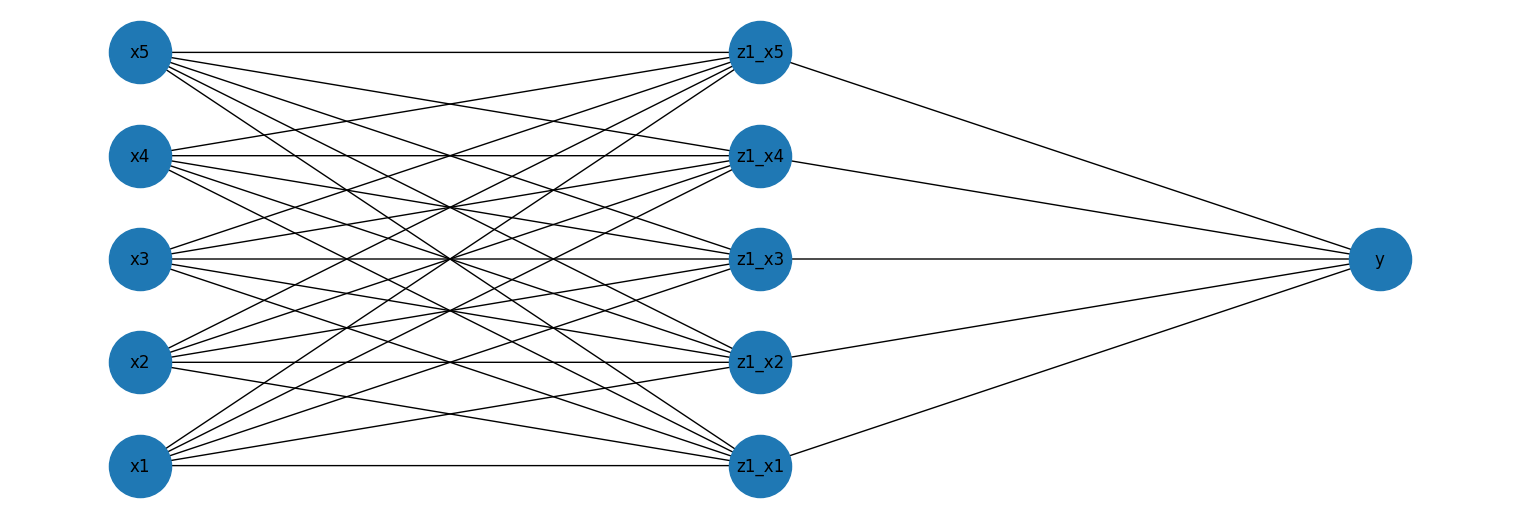

In [14]:
nn = NeuralNet()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
#no border
_ = fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
_ = ax.axis('off')
_ = nn.plot_network_graph(ax)

## Experimentación Manual

100%|██████████| 1000/1000 [00:04<00:00, 213.21it/s]


y_true       -0.78493388403920005825
y_pred        0.04644429809316898139
train_loss    0.49291611515743027905
test_loss     0.38889678935929999914
dtype: float64

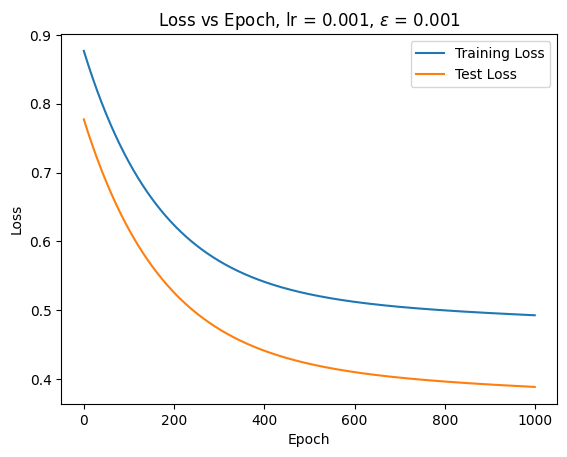

In [40]:
nn = NeuralNet()
nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001, verbose=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0],
        nn.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))
_ = nn.plot_loss()

100%|██████████| 1000/1000 [00:04<00:00, 217.11it/s]


y_true       -0.78493388403920005825
y_pred        0.37173661677270997128
train_loss    0.32651187070896015019
test_loss     0.26041518549200837196
dtype: float64

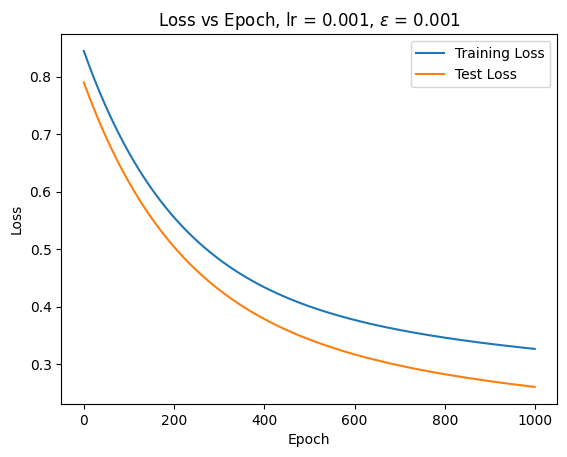

In [41]:
nn = NeuralNet()
nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001, custom_activation=nn.tanh, verbose=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0],
        nn.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))
_ = nn.plot_loss()

100%|██████████| 1000/1000 [00:04<00:00, 203.91it/s]


y_true       -0.78493388403920005825
y_pred        0.08025188324811094454
train_loss    0.48180744092102856246
test_loss     0.37801269621675831489
dtype: float64

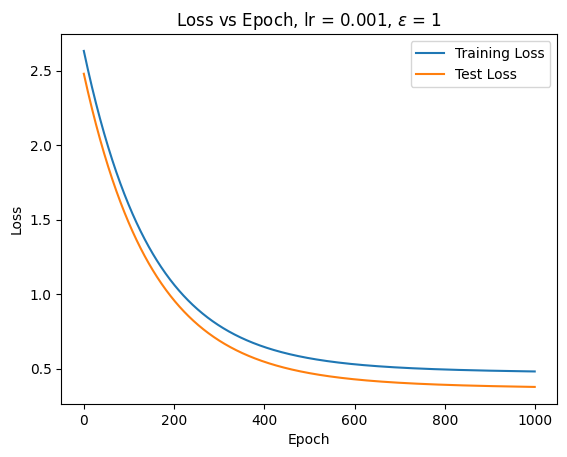

In [42]:
nn = NeuralNet()
nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001, eps=1, verbose=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0],
        nn.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))
_ = nn.plot_loss()

100%|██████████| 1000/1000 [00:04<00:00, 212.86it/s]


y_true       -0.78493388403920005825
y_pred        0.45866524525592922146
train_loss    0.46944355148992050752
test_loss     0.36192300817921502221
dtype: float64

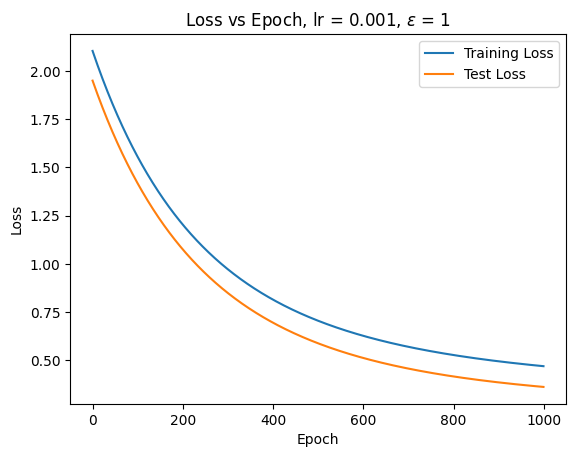

In [43]:
nn = NeuralNet()
nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001, eps=1, custom_activation=nn.tanh, verbose=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0],
        nn.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))
_ = nn.plot_loss()

Probamos tambian aplicar una mascara a los pesos de entrenamiento de la red con cierta probabilidad en cada epoch para ir variando como cada peso afecta a la red.

100%|██████████| 1000/1000 [00:02<00:00, 412.35it/s]


y_true           -0.78493388403920005825
y_pred            0.99765222048009838396
train_loss        1.00351556558170207367
test_loss         0.90571631472648683747
min_train_loss    1.00351556558170207367
min_test_loss     0.90571631472648683747
dtype: float64

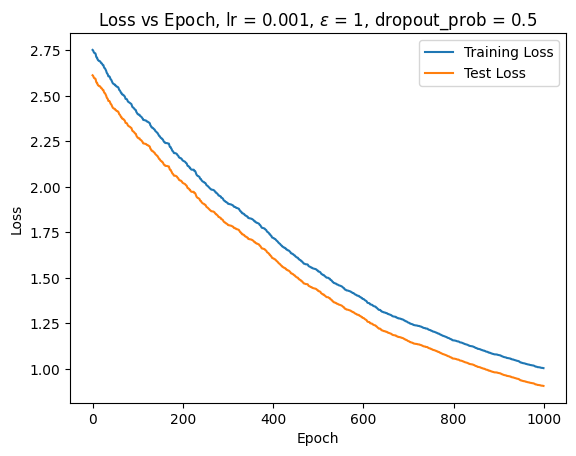

In [44]:
nn_dropout = NeuralNet()
nn_dropout.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001, eps=1, dropout=True, dropout_prob=0.5, verbose=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn_dropout.predict(X_test[0].reshape(1, -1))[0][0],
        nn_dropout.get_training_loss()[-1][0],
        nn_dropout.get_test_loss()[-1][0],
        min(nn_dropout.get_training_loss())[0],
        min(nn_dropout.get_test_loss())[0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss", "min_train_loss", "min_test_loss"]
))
_ = nn_dropout.plot_loss()

100%|██████████| 1000/1000 [00:02<00:00, 396.18it/s]


y_true           -0.78493388403920005825
y_pred            1.71298770335327654735
train_loss        1.06662901547108490696
test_loss         1.03255335968364359012
min_train_loss    1.06662901547108490696
min_test_loss     1.03255335968364359012
dtype: float64

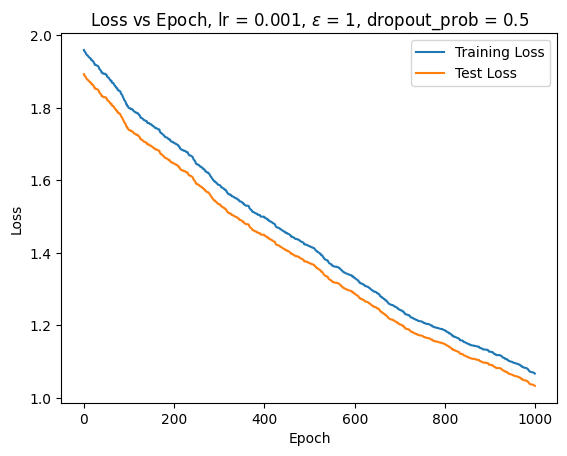

In [45]:
nn_dropout = NeuralNet()
nn_dropout.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001, eps=1, dropout=True, dropout_prob=0.5, custom_activation=nn.tanh, verbose=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn_dropout.predict(X_test[0].reshape(1, -1))[0][0],
        nn_dropout.get_training_loss()[-1][0],
        nn_dropout.get_test_loss()[-1][0],
        min(nn_dropout.get_training_loss())[0],
        min(nn_dropout.get_test_loss())[0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss", "min_train_loss", "min_test_loss"]
))
_ = nn_dropout.plot_loss()

In [46]:
nn_dropout = NeuralNet()
nn_dropout.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=10000, lr=0.001, eps=1, dropout=True, dropout_prob=0.8, verbose=True)

100%|██████████| 10000/10000 [00:38<00:00, 261.48it/s]


[]

In [47]:
display(pd.Series(
    [
        y_test[0][0], 
        nn_dropout.predict(X_test[0].reshape(1, -1))[0][0],
        nn_dropout.get_training_loss()[-1][0],
        nn_dropout.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))

y_true       -0.78493388403920005825
y_pred        0.11360940393590962527
train_loss    0.36383300713312732855
test_loss     0.28215272339976577021
dtype: float64

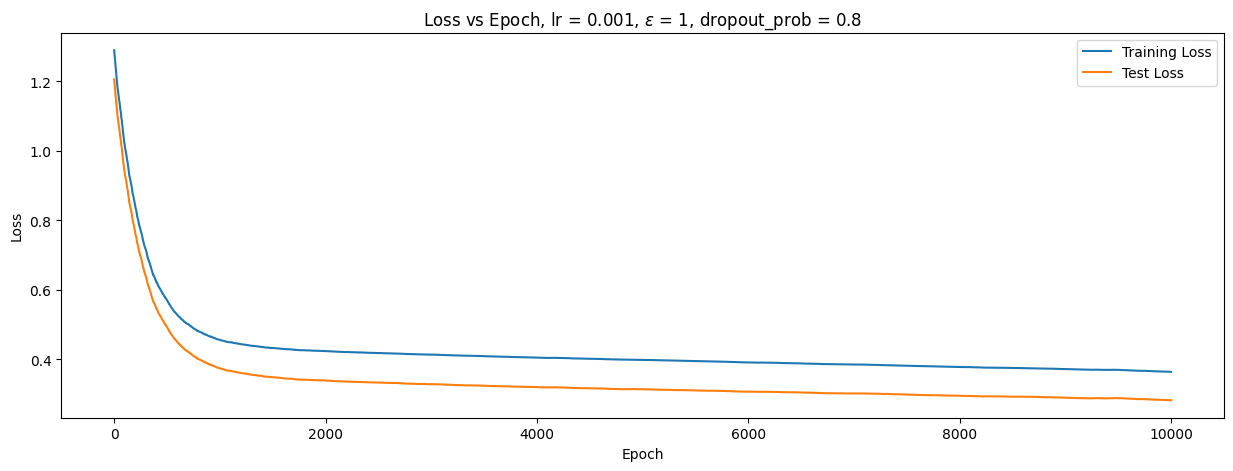

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
_ = nn_dropout.plot_loss(ax=ax)

y_true       -0.78493388403920005825
y_pred        0.86535090873625508667
train_loss    0.78510931750731127732
test_loss     0.70733865017666142094
dtype: float64

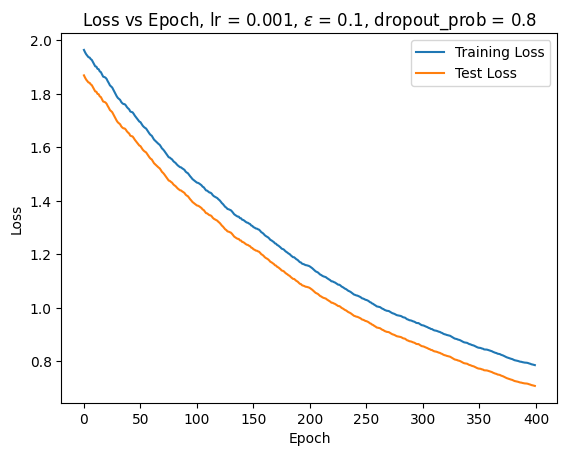

In [49]:
nn_400_dropout = NeuralNet()
nn_400_dropout.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=400, lr=0.001, eps=0.1, dropout=True, dropout_prob=0.8)
display(pd.Series(
    [
        y_test[0][0], 
        nn_400_dropout.predict(X_test[0].reshape(1, -1))[0][0],
        nn_400_dropout.get_training_loss()[-1][0],
        nn_400_dropout.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))
_ = nn_400_dropout.plot_loss()

In [ ]:
hyper_nn = NeuralNet()
hyper_nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=50000, lr=0.001, eps=1, dropout=True, dropout_prob=0.8)

In [ ]:
display(pd.Series(
    [
        y_test[0][0], 
        hyper_nn.predict(X_test[0].reshape(1, -1))[0][0],
        hyper_nn.get_training_loss()[-1][0],
        hyper_nn.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_1661/2190381686.py:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


y_true       27.30000000000000071054
y_pred       28.12064270715838176784
train_loss   96.12452944561505319143
test_loss    79.64967781583217742991
dtype: float64

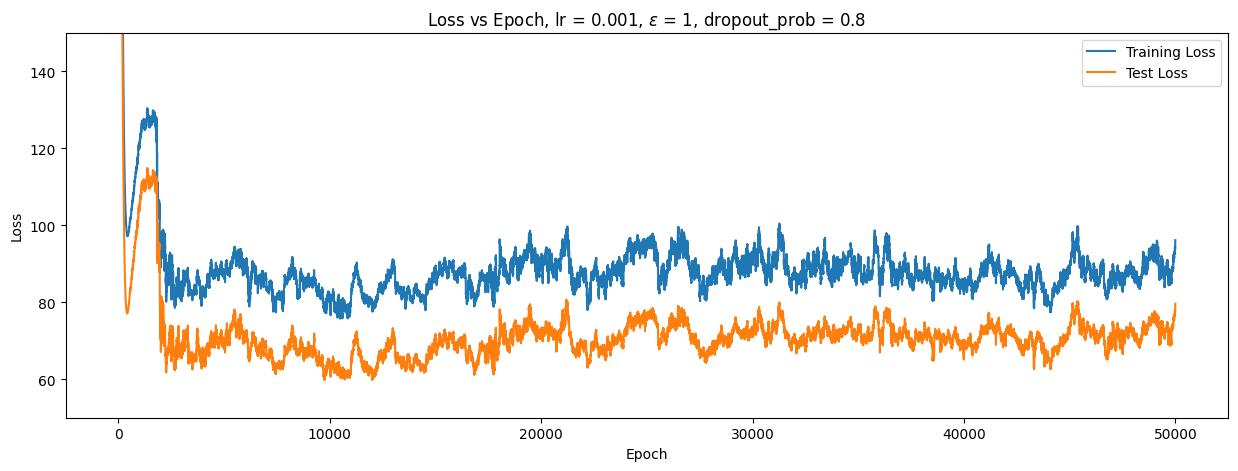

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
hyper_nn.plot_loss(ax=ax)

In [ ]:
# Epoch en el que se obtuvo la menor Loss

m = min(hyper_nn.get_training_loss(), key=lambda x: x[0])
e = hyper_nn.get_training_loss().index(m)

print(f"Lowest training loss: {m[0]:.2f} at epoch {e}")

Lowest training loss: 75.74 at epoch 10480


In [ ]:
hyper_nn_ = NeuralNet()
hyper_nn_.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=e, lr=0.001, eps=1, dropout=True, dropout_prob=0.8)

y_true       -0.78493388403920005825
y_pred        0.21821376222853636206
train_loss    0.51330277125273682248
dtype: float64

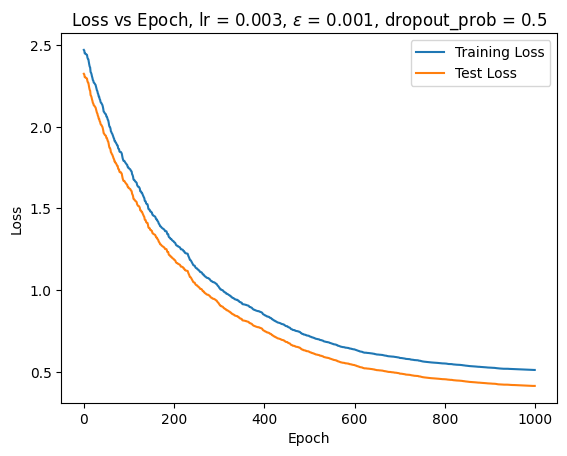

In [51]:
nn = NeuralNet()
loss = nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.003, epochs=1000, dropout=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0]
    ], 
    index=["y_true", "y_pred", "train_loss"]
))
_ = nn.plot_loss()

y_true       -0.78493388403920005825
y_pred        1.92172363413830371570
train_loss    2.95185691911466374648
dtype: float64

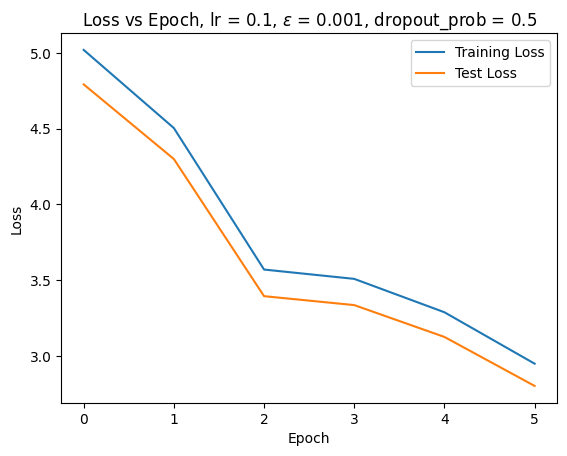

In [52]:
nn = NeuralNet()
loss = nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.1, epochs=6, dropout=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0]
    ], 
    index=["y_true", "y_pred", "train_loss"]
))
_ = nn.plot_loss()

y_true       -0.78493388403920005825
y_pred        1.49461707506403440604
train_loss    1.67332470222924700742
dtype: float64

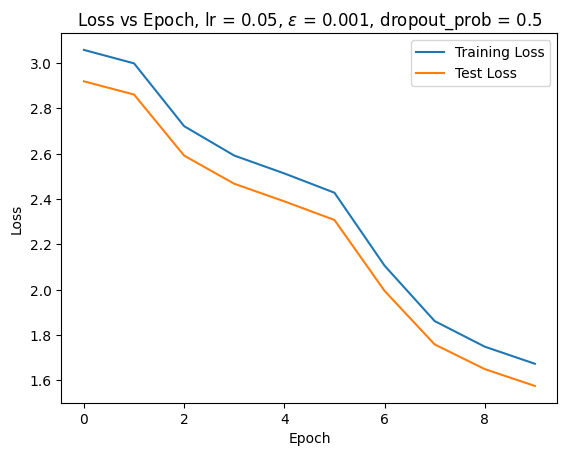

In [53]:
nn = NeuralNet()
loss = nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.05, epochs=10, dropout=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0]
    ], 
    index=["y_true", "y_pred", "train_loss"]
))
_ = nn.plot_loss()

## Otras funciones de activación

Para la función de activación probamos con la función sigmoide como indicaba la consigna, y ademas con la funciones ReLU, Leaky Relu y Tanh.

$$
\text{ReLU}(x) = \max(0, x) \\
\text{LeakyReLU}(x) = \max(0.01x, x) \\
\text{Tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

### ReLu

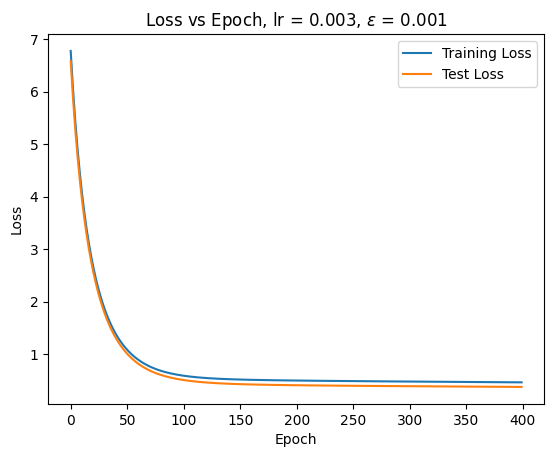

In [54]:
nn_relu = NeuralNet()
nn_relu.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.003, epochs=400, custom_activation=nn.relu)
_ = nn_relu.plot_loss()

### Leaky ReLu

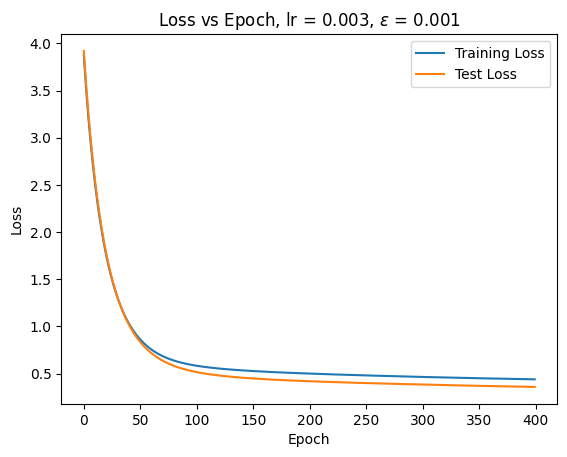

In [55]:
nn_leaky = NeuralNet()
nn_leaky.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.003, epochs=400, custom_activation=nn.leaky_relu)
_ = nn_leaky.plot_loss()

### Tanh

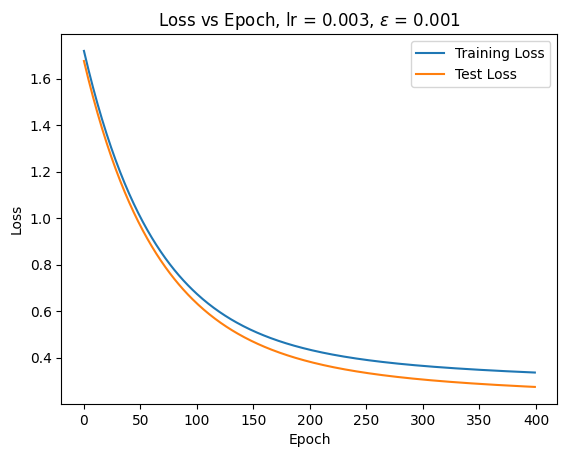

In [56]:
nn_tanh = NeuralNet()
nn_tanh.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.003, epochs=400, custom_activation=nn.tanh)
_ = nn_tanh.plot_loss()

Aca una comparación entre las funciones de activación.

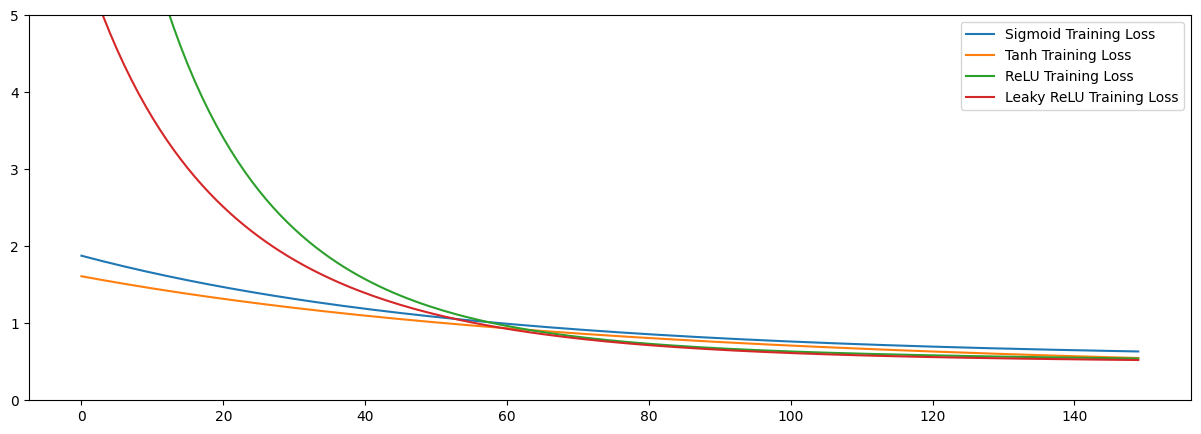

In [212]:
np.random.seed(42)

fig, ax = plt.subplots(figsize=(15, 5))

nn = NeuralNet()
nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.003, epochs=150)

nn_tanh = NeuralNet()
nn_tanh.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.003, epochs=150, custom_activation=nn.tanh)

nn_relu = NeuralNet()
nn_relu.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.003, epochs=150, custom_activation=nn.relu)

nn_leaky = NeuralNet()
nn_leaky.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.003, epochs=150, custom_activation=nn.leaky_relu)

ax.plot(nn.get_training_loss(), label="Sigmoid Training Loss")
#ax.plot(nn.get_test_loss(), label="Sigmoid Test Loss")

ax.plot(nn_tanh.get_training_loss(), label="Tanh Training Loss")
#ax.plot(nn_tanh.get_test_loss(), label="Tanh Test Loss")

ax.plot(nn_relu.get_training_loss(), label="ReLU Training Loss")
#ax.plot(nn_relu.get_test_loss(), label="ReLU Test Loss")

ax.plot(nn_leaky.get_training_loss(), label="Leaky ReLU Training Loss")
#ax.plot(nn_leaky.get_test_loss(), label="Leaky ReLU Test Loss")

_ = ax.legend()
_ = ax.set_ylim(0, 5)

## Distintos valores de Learning Rate para distintos Epochs

In [66]:
# Brute force para encontrar el mejor número de epochs y learning rate

lrs = np.linspace(0.001, 0.5, 10).round(3)
eps = list(range(1, 1000, 50))

train_losses = {}
test_losses = {}

for lr, ep in tqdm(list(itertools.product(lrs, eps))):
    nn = NeuralNet()
    nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=lr, epochs=int(ep))
    
    train_losses[(lr, int(ep))] = nn.get_training_loss()[-1][0]
    test_losses[(lr, int(ep))] = nn.get_test_loss()[-1][0]

100%|██████████| 200/200 [07:13<00:00,  2.17s/it]


In [67]:
train_losses_arr = []
test_losses_arr = []

for (lr, ep), loss in train_losses.items():
    train_losses_arr.append((lr, int(ep), loss))

for (lr, ep), loss in test_losses.items():
    test_losses_arr.append((lr, int(ep), loss))

train_losses_df = pd.DataFrame(train_losses_arr, columns=['lr', 'epochs', 'loss'])
test_losses_df = pd.DataFrame(test_losses_arr, columns=['lr', 'epochs', 'loss'])

# merge dataframes
losses_df = pd.merge(train_losses_df, test_losses_df, on=['lr', 'epochs'], suffixes=('_train', '_test'))
losses_df

lr  epochs             loss_train  \
0   0.00100000000000000002       1 1.87743810835628810452   
1   0.00100000000000000002      51 1.89809683458009725854   
2   0.00100000000000000002     101 2.05586038626800693407   
3   0.00100000000000000002     151 1.39752316532863019027   
4   0.00100000000000000002     201 1.10785955112185008353   
..                     ...     ...                    ...   
195 0.50000000000000000000     751 0.16332172313294190946   
196 0.50000000000000000000     801 0.16246558768882812807   
197 0.50000000000000000000     851 0.16459487563463018334   
198 0.50000000000000000000     901 0.15320961758829265698   
199 0.50000000000000000000     951 0.15329495011639915347   

                 loss_test  
0   1.73476852734837727610  
1   1.82285504558099198391  
2   1.92997236528647286846  
3   1.30038075450488399554  
4   1.02301512913471515098  
..                     ...  
195 0.13605168612603182887  
196 0.13128416614230734027  
197 0.12912932271711066723  
198 0.12323641841117415063  
199 0.11944339314836582844  

[200 rows x 4 columns]

In [68]:
losses_df.sort_values(by='loss_test', ascending=True).head(10)

lr  epochs             loss_train  \
199 0.50000000000000000000     951 0.15329495011639915347   
176 0.44500000000000000666     801 0.15746876617568505985   
198 0.50000000000000000000     901 0.15320961758829265698   
154 0.38900000000000001243     701 0.16111992730361043846   
137 0.33400000000000001910     851 0.16117423469854277873   
172 0.44500000000000000666     601 0.16218132074476054871   
153 0.38900000000000001243     651 0.16905502207210718058   
157 0.38900000000000001243     851 0.16408678182910671484   
175 0.44500000000000000666     751 0.15873028249133064316   
119 0.27800000000000002487     951 0.16411438059864982830   

                 loss_test  
199 0.11944339314836582844  
176 0.12089535773986052891  
198 0.12323641841117415063  
154 0.12472578371511933160  
137 0.12491313318531337140  
172 0.12520634705450128799  
153 0.12743352411408995217  
157 0.12782819231539907512  
175 0.12801320986806410951  
119 0.12836008824100647585

In [69]:
losses_df.sort_values(by='loss_train', ascending=True).head(10)

lr  epochs             loss_train  \
198 0.50000000000000000000     901 0.15320961758829265698   
199 0.50000000000000000000     951 0.15329495011639915347   
176 0.44500000000000000666     801 0.15746876617568505985   
159 0.38900000000000001243     951 0.15847154594714277231   
175 0.44500000000000000666     751 0.15873028249133064316   
136 0.33400000000000001910     801 0.16088926408117254496   
154 0.38900000000000001243     701 0.16111992730361043846   
137 0.33400000000000001910     851 0.16117423469854277873   
177 0.44500000000000000666     851 0.16121045048859991566   
158 0.38900000000000001243     901 0.16133227277333794802   

                 loss_test  
198 0.12323641841117415063  
199 0.11944339314836582844  
176 0.12089535773986052891  
159 0.13409821026209842176  
175 0.12801320986806410951  
136 0.13546491160996021463  
154 0.12472578371511933160  
137 0.12491313318531337140  
177 0.12888606166674362874  
158 0.12873463478972885232

Muchos de los valores de lr convergen a la misma loss minima ~(15.32%), pero algunos lo hacen mas rapido que otros.

En estos gráficos de calor podemos ver como la mayoría de los learning rates mayores a 0.1 para cierto epoch logran converger a este mismo valor.

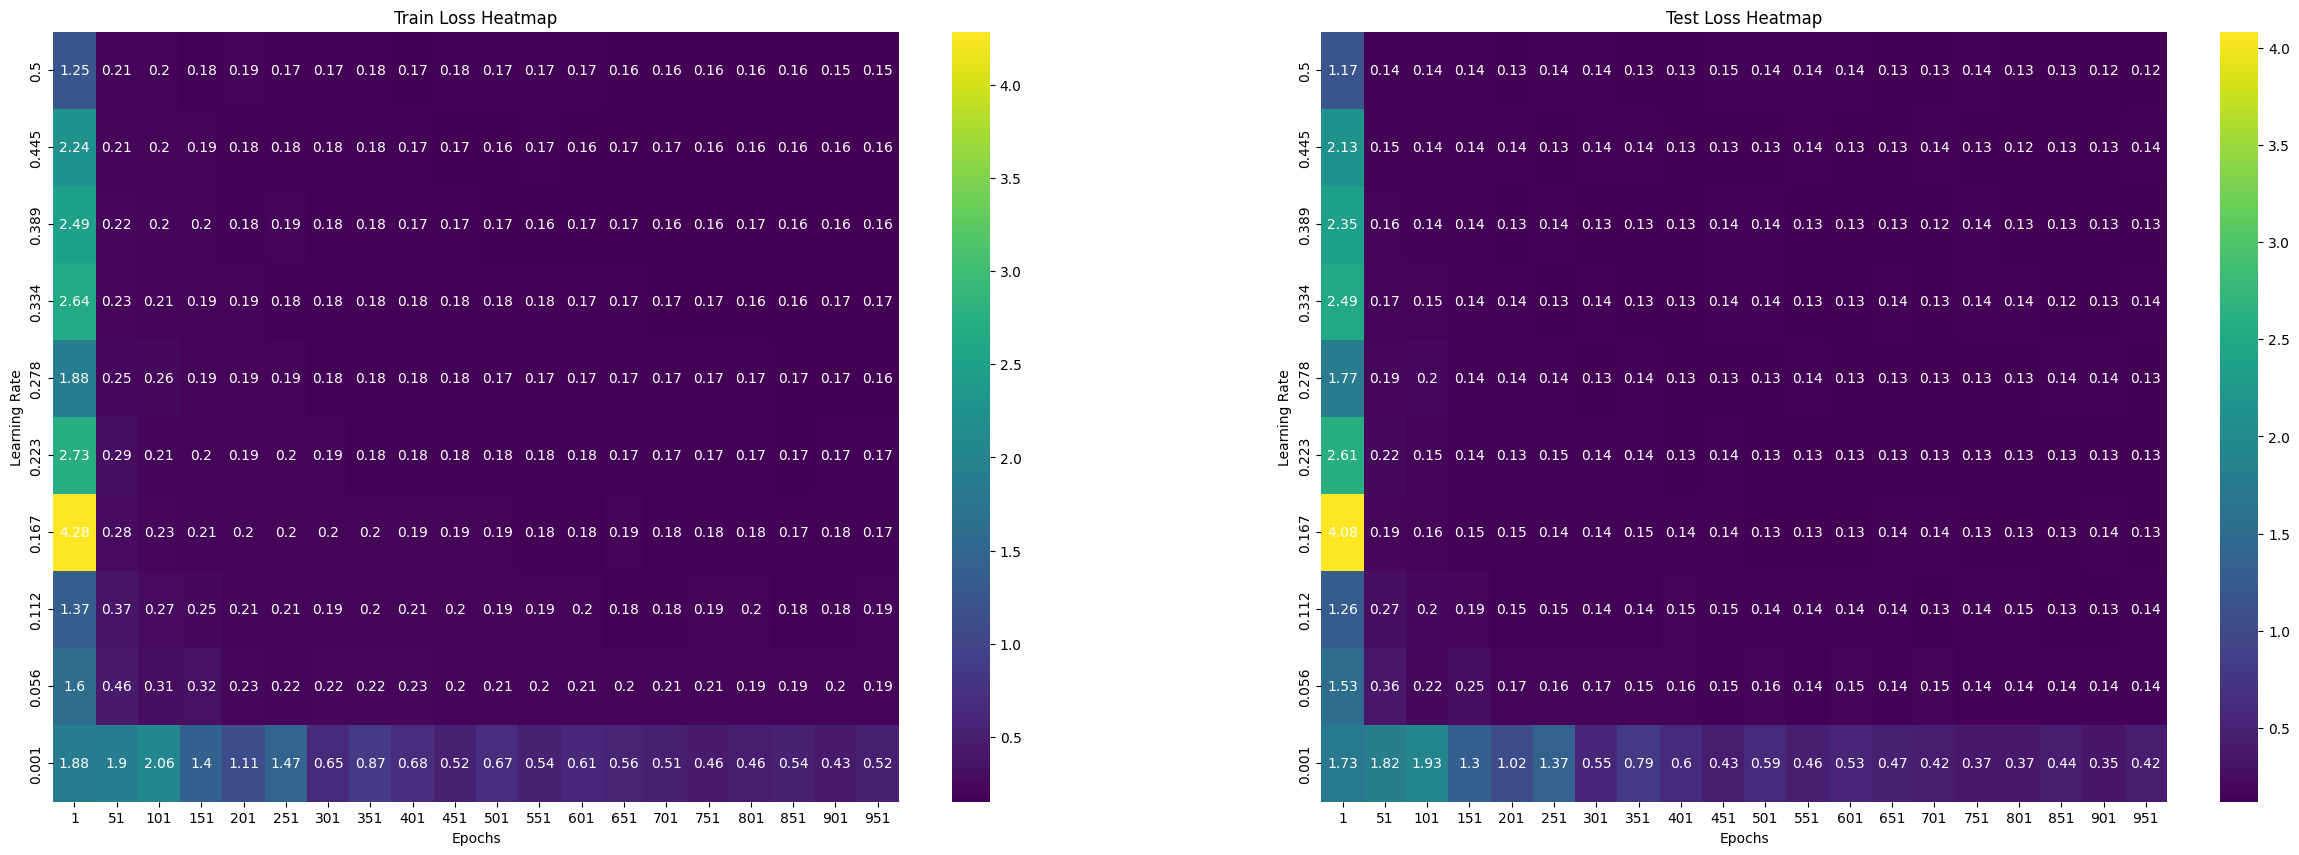

In [215]:
losses_df_hm_test = losses_df.pivot(index='lr', columns='epochs', values='loss_test')
losses_df_hm_train = losses_df.pivot(index='lr', columns='epochs', values='loss_train')

fig, axs = plt.subplots(1, 2, figsize=(30, 10))

sns.heatmap(losses_df_hm_train, ax=axs[0], cmap='viridis')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Learning Rate')
axs[0].set_title('Train Loss Heatmap')
axs[0].invert_yaxis()
# add the value to each cell in the heatmap
for i in range(losses_df_hm_train.shape[0]):
    for j in range(losses_df_hm_train.shape[1]):
        axs[0].text(j + 0.5, i + 0.5, round(losses_df_hm_train.iloc[i, j], 2),
                    ha="center", va="center", color="w")

sns.heatmap(losses_df_hm_test, ax=axs[1], cmap='viridis')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Learning Rate')
axs[1].set_title('Test Loss Heatmap')
axs[1].invert_yaxis()

# add the value to each cell in the heatmap
for i in range(losses_df_hm_test.shape[0]):
    for j in range(losses_df_hm_test.shape[1]):
        axs[1].text(j + 0.5, i + 0.5, round(losses_df_hm_test.iloc[i, j], 2),
                    ha="center", va="center", color="w")

plt.show()

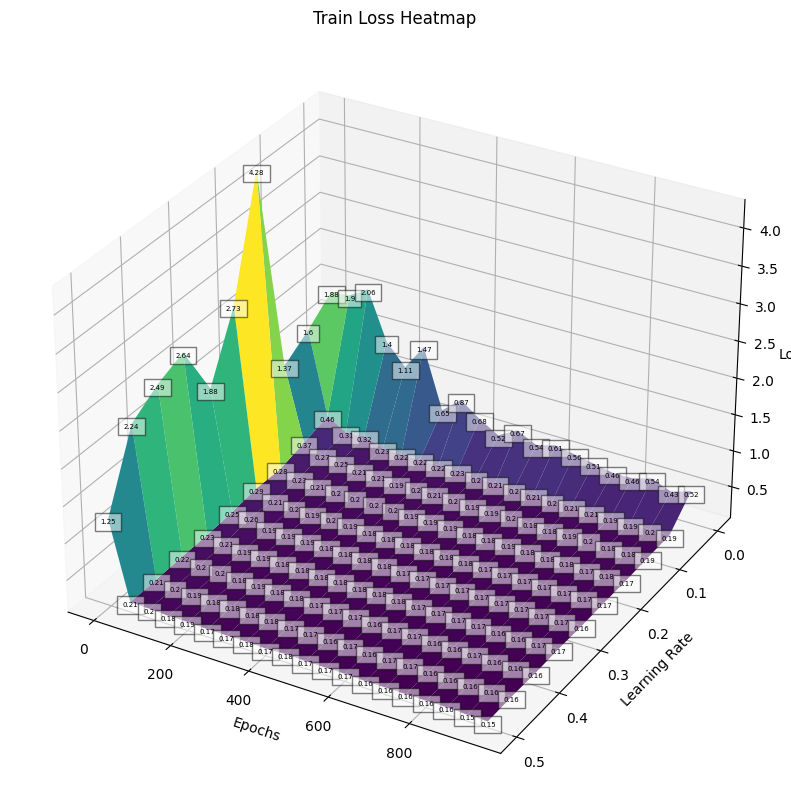

In [236]:
#3d plot of the heatmap losses_df_hm_train
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

x = np.array(losses_df_hm_train.columns)
y = np.array(losses_df_hm_train.index)
X, Y = np.meshgrid(x, y)
Z = np.array(losses_df_hm_train)

ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('Epochs')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Loss')
ax.set_title('Train Loss Heatmap')
ax.invert_yaxis()

# add text anotations to extreme values

# get the index of the minimum value
min_idx = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
# get the index of the maximum value
max_idx = np.unravel_index(np.argmax(Z, axis=None), Z.shape)

# add the value to each cell in the heatmap
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        ax.text(x[j], y[i], Z[i, j], round(Z[i, j], 2),
                color="black", fontsize=5, ha="center", va="top", bbox=dict(facecolor='white', alpha=0.5))



Para lograr obtener una menor Loss, probamos modificando el valor de Epsilon

y_true       -0.78493388403920005825
y_pred        0.35418042197242027846
train_loss    0.56107902942967169402
dtype: float64

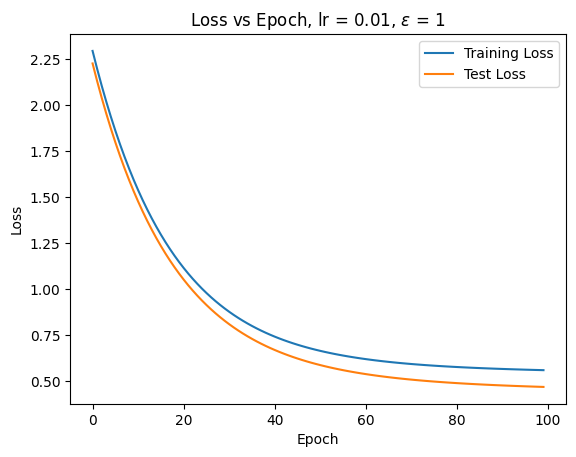

In [81]:
nn = NeuralNet()
loss = nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.01, epochs=100, eps=1)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0]
    ], 
    index=["y_true", "y_pred", "train_loss"]
))

_ = nn.plot_loss()

## Combinaciones de Learning Rate y Epsilon

Buscamos ver como variando el Epsilon junto al Learning Rate para una cantidad fija arbitraria de epochs podemos encontrar un valor de lr que converja mas rápido sobre los modelos con las funciones de activación Tanh y Sigmoide, esta última con y sin Dropout de pesos. Ademas, vamos a ver como cambia la loss minima para cuando finalice el entrenamiento.

In [82]:
# Brute force, best learning rate, epsilons, with and without dropout

lrs = np.linspace(0.001, 0.5, 10).round(3)
#epochs = list(range(0, 1050, 50))[1:]
epochs = [500] # Se podría probar con distintos epochs, idealmente valores mayores, los anteriores se pueden obtener como "early stops"
epsilons = list(map(lambda x: x/10000, range(0, 10005, 500)[1:]))

In [83]:
len(epsilons), len(lrs), len(epochs)

(20, 10, 1)

In [84]:
len(list(itertools.product(lrs, epochs, epsilons)))

200

In [92]:
losses = {
    'default': {
        'train': {},
        'test': {}
    },
    'tanh': {
        'train': {},
        'test': {}
    },
    'relu': {
        'train': {},
        'test': {}
    },
    'leaky_relu': {
        'train': {},
        'test': {}
    },
    'dropout': {
        'train': {},
        'test': {}
    },
}

In [93]:
np.random.seed(42)

for lr, ep, eps in tqdm(list(itertools.product(lrs, epochs, epsilons))):

    nn = NeuralNet()
    nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=lr, epochs=int(ep), eps=eps)
    losses['default']['train'][lr, ep, eps] = nn.get_training_loss()
    losses['default']['test'][lr, ep, eps] = nn.get_test_loss()

    nn_drop = NeuralNet()
    nn_drop.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=lr, epochs=int(ep), eps=eps, dropout=True)
    losses['dropout']['train'][lr, ep, eps] = nn_drop.get_training_loss()
    losses['dropout']['test'][lr, ep, eps] = nn_drop.get_test_loss()

    nn_tanh = NeuralNet()
    nn_tanh.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=lr, epochs=int(ep), eps=eps, custom_activation=nn_tanh.tanh)
    losses['tanh']['train'][lr, ep, eps] = nn_tanh.get_training_loss()
    losses['tanh']['test'][lr, ep, eps] = nn_tanh.get_test_loss()

    nn_relu = NeuralNet()
    nn_relu.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=lr, epochs=int(ep), eps=eps, custom_activation=nn_relu.relu)
    losses['relu']['train'][lr, ep, eps] = nn_relu.get_training_loss()
    losses['relu']['test'][lr, ep, eps] = nn_relu.get_test_loss()

    nn_leaky_relu = NeuralNet()
    nn_leaky_relu.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=lr, epochs=int(ep), eps=eps, custom_activation=nn_leaky_relu.leaky_relu)
    losses['leaky_relu']['train'][lr, ep, eps] = nn_leaky_relu.get_training_loss()
    losses['leaky_relu']['test'][lr, ep, eps] = nn_leaky_relu.get_test_loss()

100%|██████████| 200/200 [31:14<00:00,  9.37s/it]


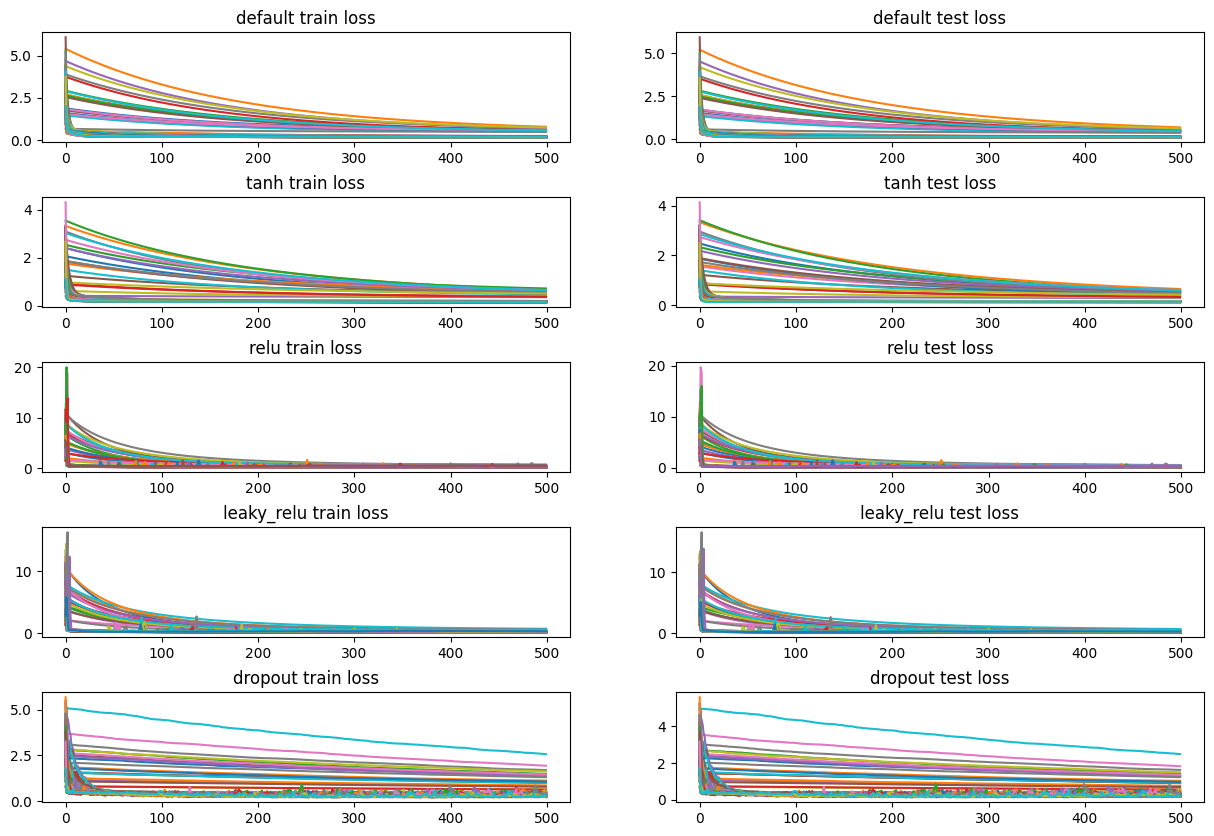

In [163]:
fig, axs = plt.subplots(len(losses.keys()), 2, figsize=(15, 10))

for i, (variation, train_test) in enumerate(losses.items()):
    for (lr, ep, eps), loss in train_test['train'].items():
        # De forma empírica observamos que con pesos aleatorios, la loss comienza al rededor de ~700
        # Evitamos en el gráfico aquellos que superen en algún momento esa loss para limpiar
        if any([l > 20 for l in loss]):
            continue
        axs[i, 0].plot(loss, label=f'lr={lr}, ep={ep}, eps={eps}')

    
    for (lr, ep, eps), loss in train_test['test'].items():
        if any([l > 20 for l in loss]):
            continue
        axs[i, 1].plot(loss, label=f'lr={lr}, ep={ep}, eps={eps}')

    axs[i, 0].set_title(f'{variation} train loss')
    axs[i, 1].set_title(f'{variation} test loss')

# Add space between subplots
fig.subplots_adjust(hspace=0.5)


Podemos observar como para ciertas combinaciones de Learning Rate y Epochs la convergencia es mas rápida.

Para la mascara de pesos, probamos con una probabilidad de 0.5. En todos los casos la convergencia fue o mas lenta, y la loss minima alcanzada mayor que la obtenida sin aplicar la mascara, o directamente esporádico sin convergencia.

(0.0, 1.0)

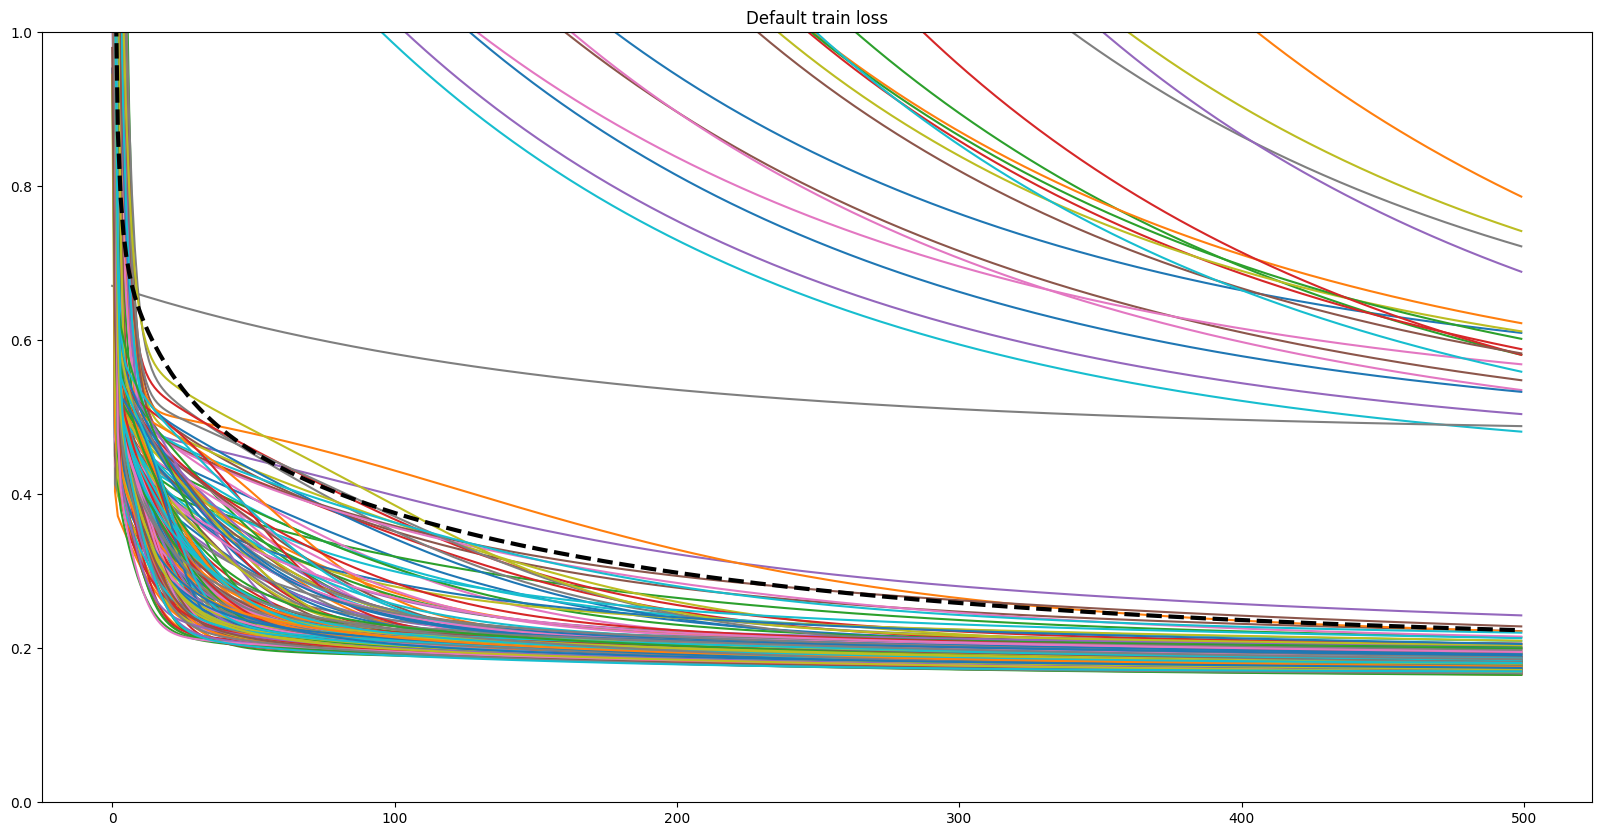

In [158]:
# Large Default Training Loss Plot
fig, ax = plt.subplots(figsize=(20, 10))

for (lr, ep, eps), loss in losses['default']['train'].items():
    
    if any([l > 20 for l in loss]):
        continue
    ax.plot(loss, label=f'lr={lr}, ep={ep}, eps={eps}')

#add mean line
ax.plot(np.mean(list(losses['default']['train'].values()), axis=0), label='mean', color='black', linestyle='--', linewidth=3)

ax.set_title(f'Default train loss')
#ax.legend()

ax.set_ylim(0, 1)

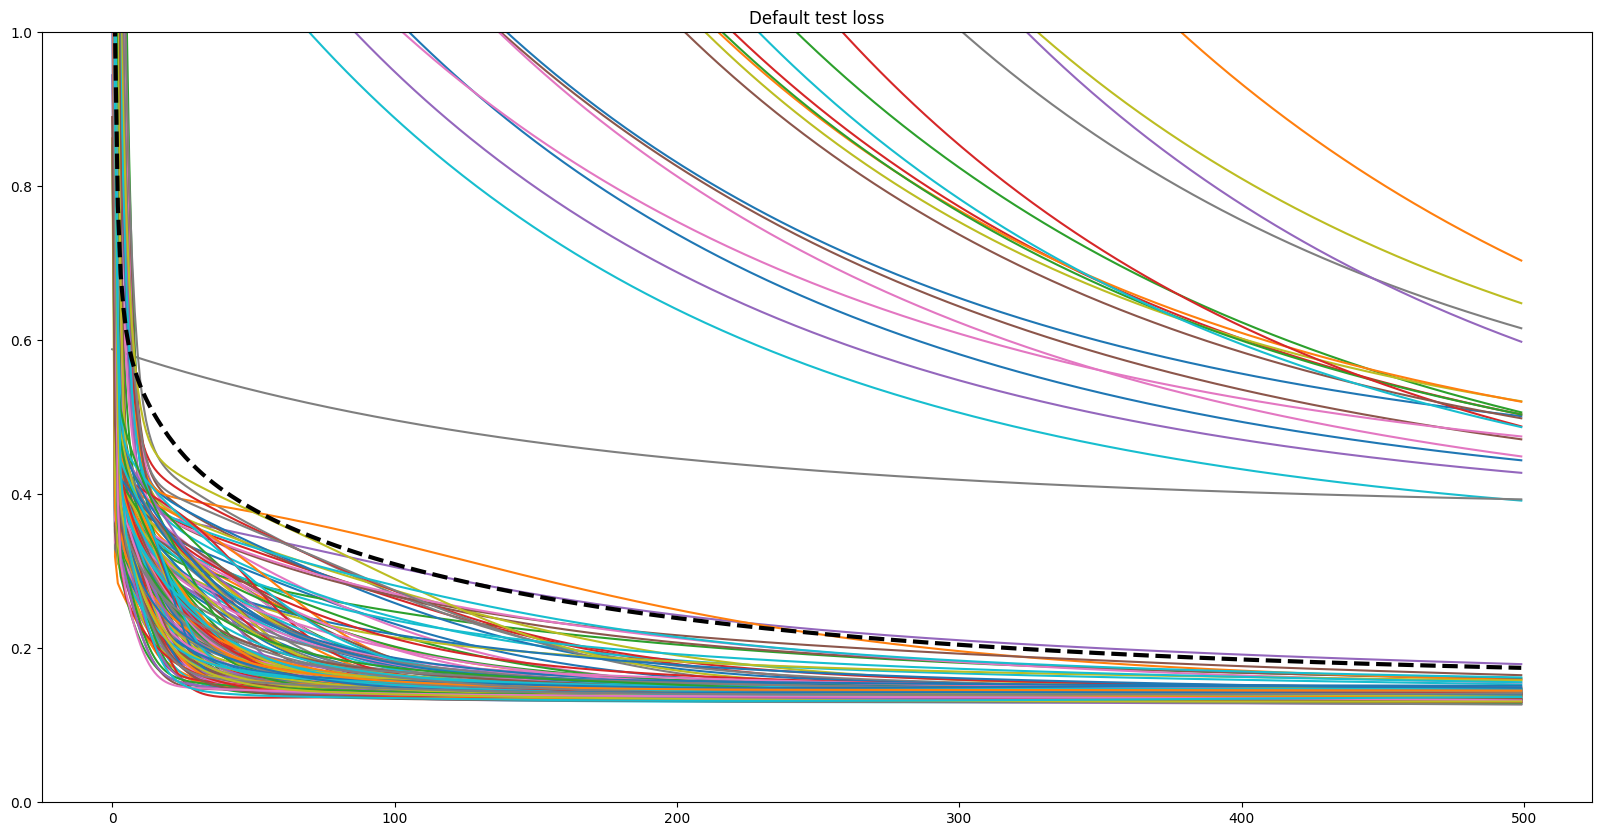

In [156]:
# Large Default Test Loss Plot
fig, ax = plt.subplots(figsize=(20, 10))

for (lr, ep, eps), loss in losses['default']['test'].items():
    if any([l > 20 for l in loss]):
        continue
    ax.plot(loss, label=f'lr={lr}, ep={ep}, eps={eps}')

# add mean line
ax.plot(np.mean(list(losses['default']['test'].values()), axis=0), label='mean', color='black', linestyle='--', linewidth=3)

_ = ax.set_title(f'Default test loss')
_ = ax.set_ylim(0, 1)

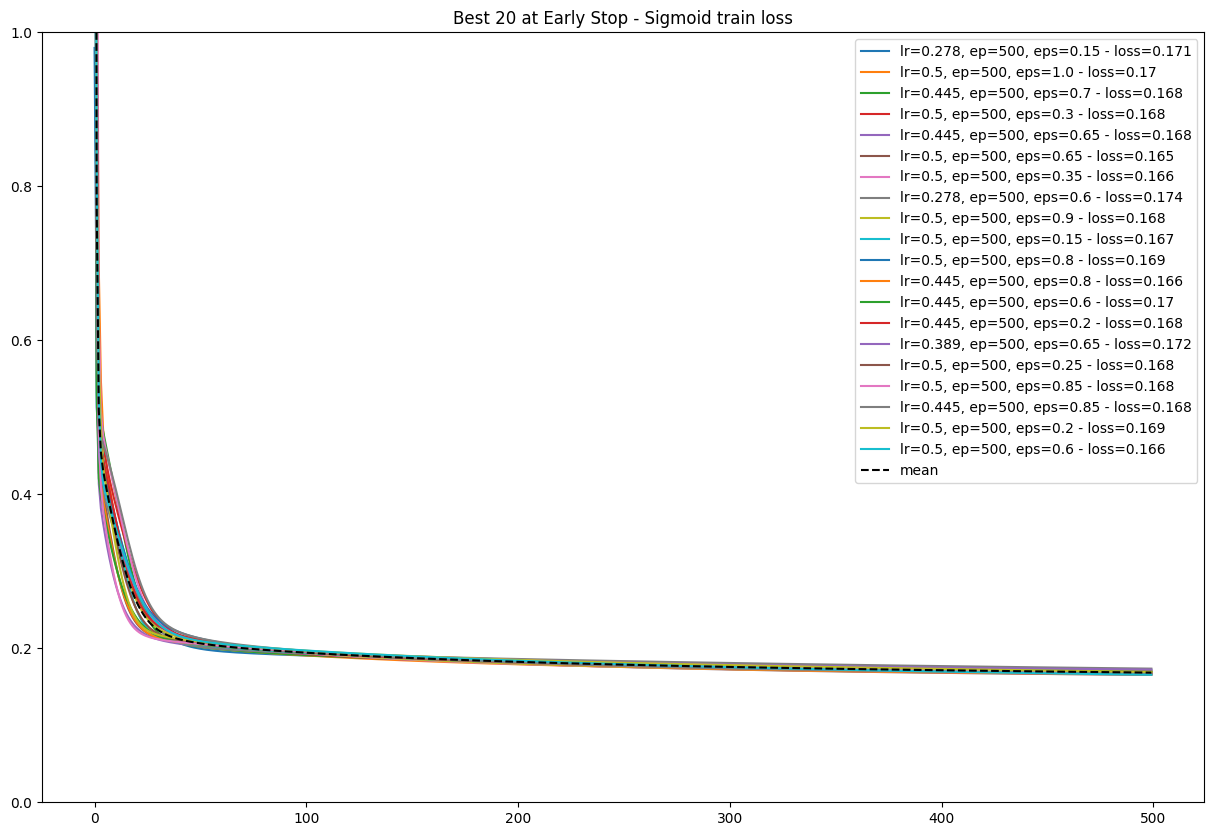

In [151]:
# Filter out the best learning rate - epsilons combinations for the Default NN
# The 20 lowest training loss by epoch 200

# Sort by the loss at epoch 250

# Plot every train_loss[:20]

fig, ax = plt.subplots(figsize=(15, 10))
 
top_sigmoid = sorted(losses['default']['train'].items(), key=lambda x: x[1][100])[:20]
for (lr, ep, eps), loss in top_sigmoid:
    ax.plot(loss, label=f'lr={lr}, ep={ep}, eps={eps} - loss={loss[-1].round(3)[0]}')

# add mean line
ax.plot(np.mean([loss for _, loss in top_sigmoid], axis=0), label='mean', color='black', linestyle='--')

_ = ax.set_title(f'Best 20 at Early Stop - Sigmoid train loss')
_ = ax.set_ylim(0, 1)
_ = ax.legend()

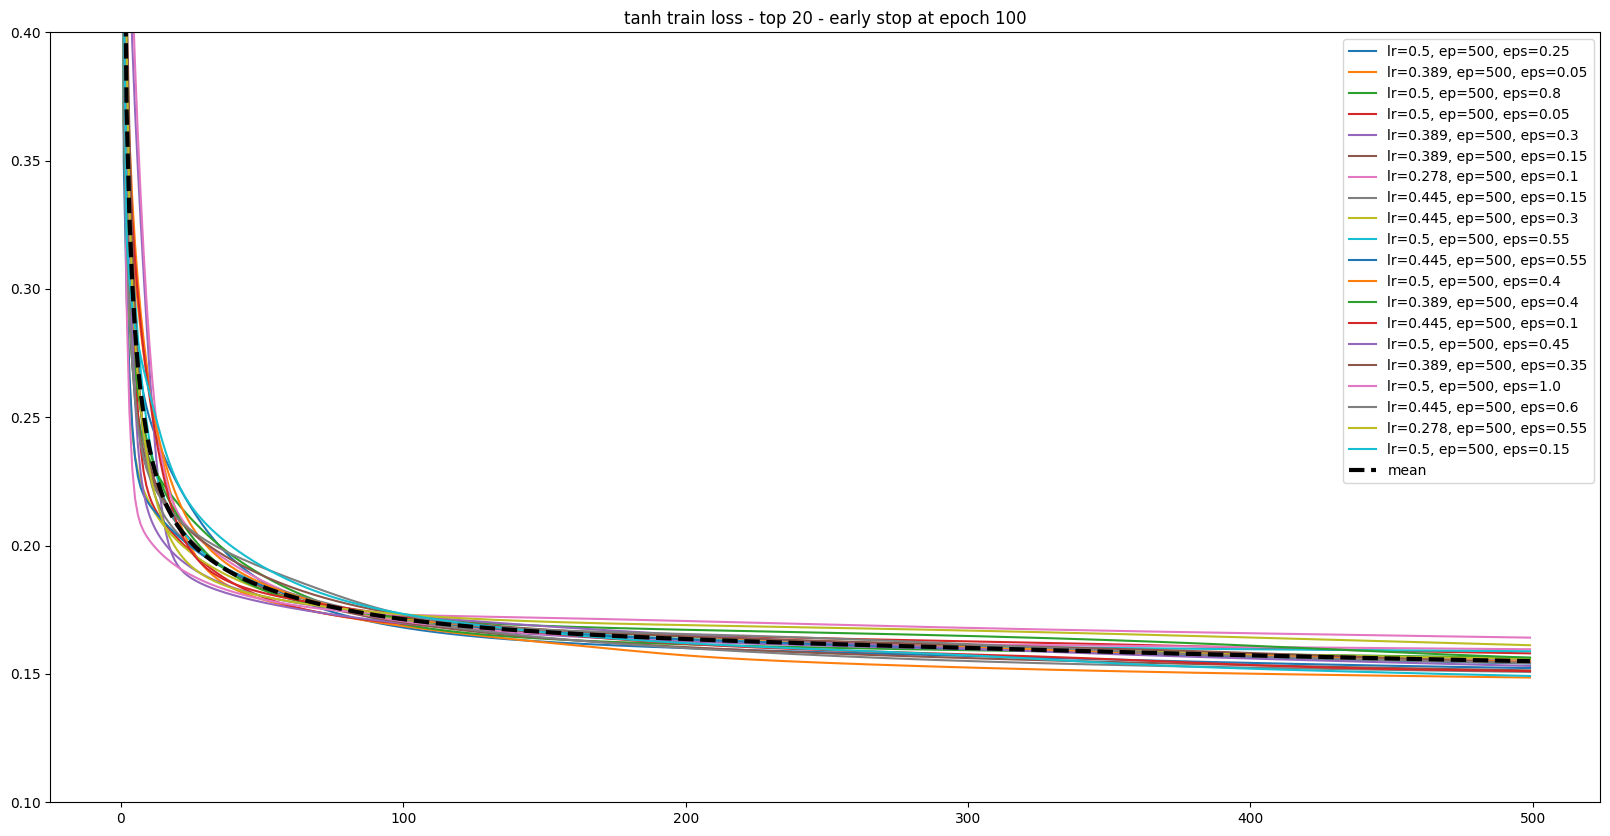

In [150]:
# Large Default Training Loss Plot
fig, ax = plt.subplots(figsize=(20, 10))

top_tanh = sorted(losses['tanh']['train'].items(), key=lambda x: x[1][100])[:20]
for (lr, ep, eps), loss in top_tanh:
    if any([l > 20 for l in loss]):
        continue
    ax.plot(loss, label=f'lr={lr}, ep={ep}, eps={eps}')

# add mean line
ax.plot(np.mean([loss for _, loss in top_tanh], axis=0), label='mean', color='black', linestyle='--', linewidth=3)

_ = ax.set_title(f'tanh train loss - top 20 - early stop at epoch 100')
_ = ax.set_ylim(0.1, 0.4)
_ = ax.legend()

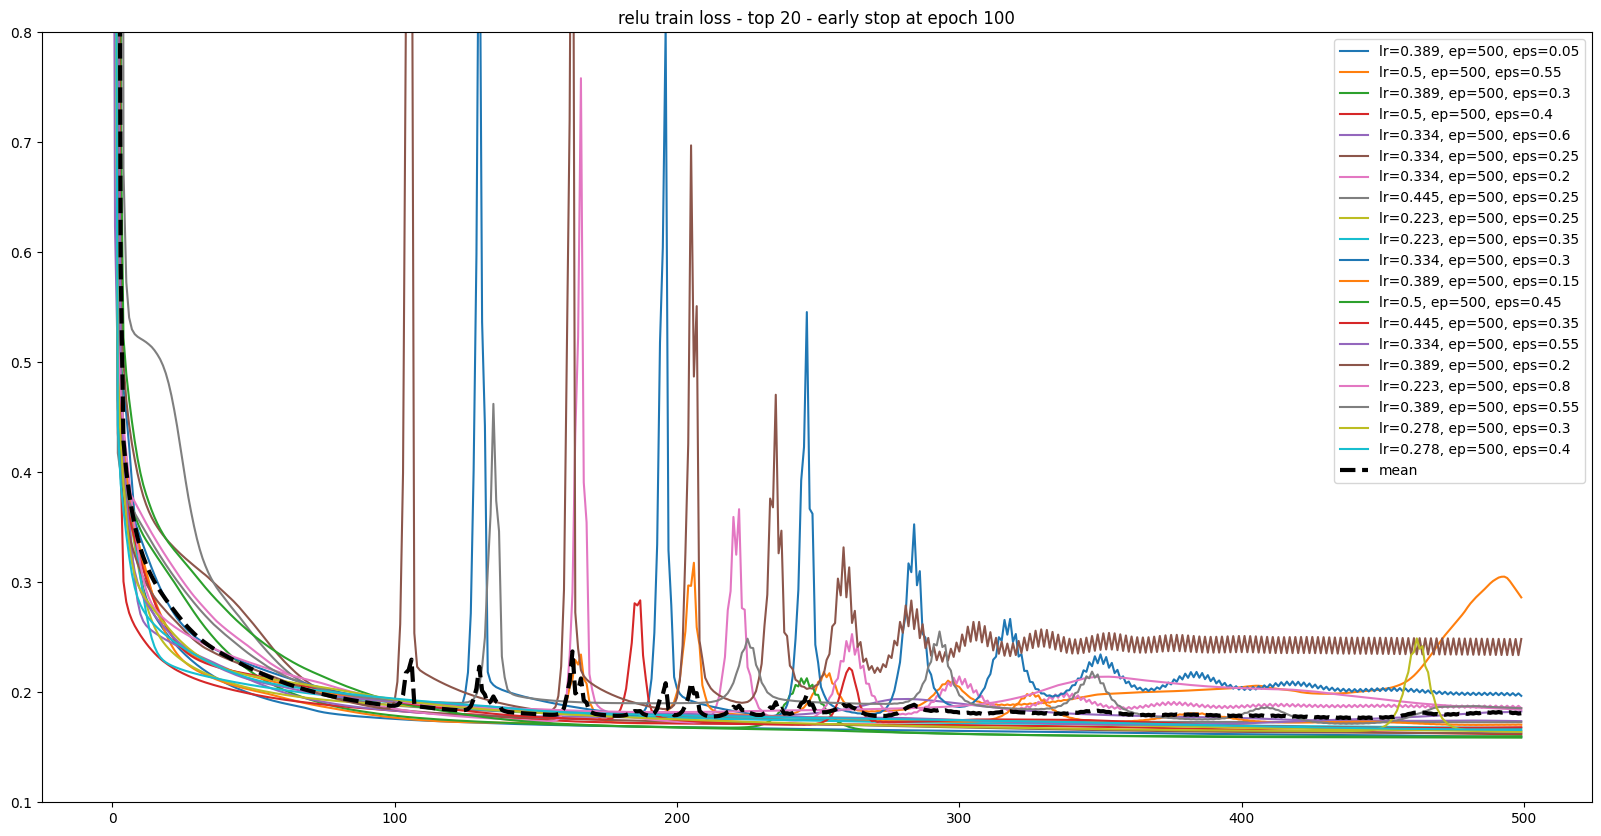

In [147]:
# Large Default Training Loss Plot
fig, ax = plt.subplots(figsize=(20, 10))

top_relu = sorted(losses['relu']['train'].items(), key=lambda x: x[1][100])[:20]
for (lr, ep, eps), loss in top_relu:
    if any([l > 20 for l in loss]):
        continue
    ax.plot(loss, label=f'lr={lr}, ep={ep}, eps={eps}')

# add mean line
ax.plot(np.mean([l for _, l in top_relu], axis=0), label='mean', color='black', linestyle='--', linewidth=3)

_ = ax.set_title(f'relu train loss - top 20 - early stop at epoch 100')
_ = ax.set_ylim(0.1, 0.8)
_ = ax.legend()

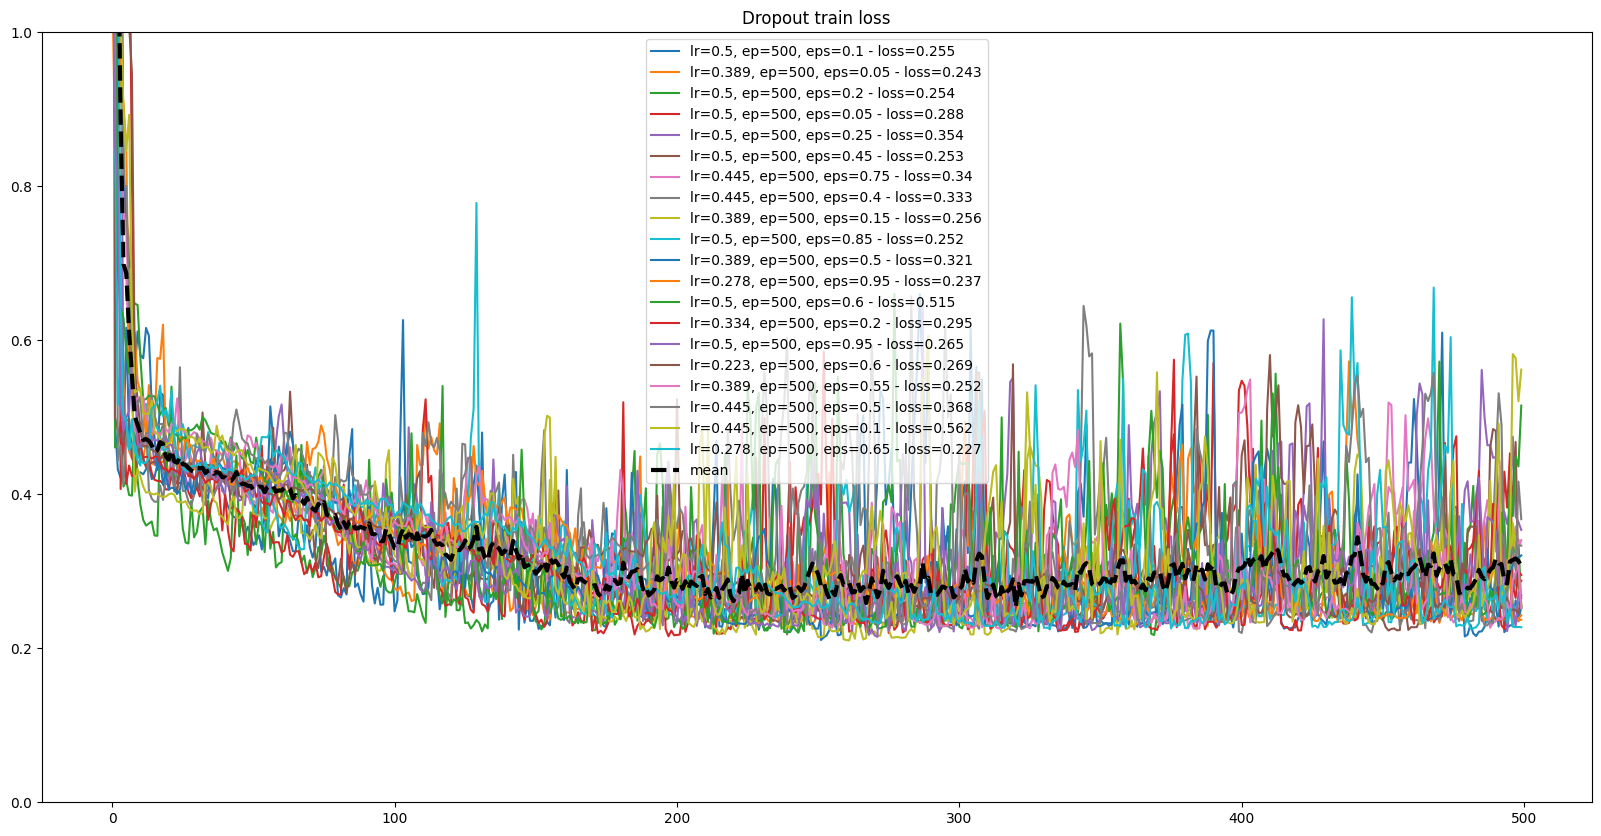

In [154]:
# Large Dropout Training Loss Plot

fig, ax = plt.subplots(figsize=(20, 10))

top_dropout = sorted(losses['dropout']['train'].items(), key=lambda x: x[1][100])[:20]
for (lr, ep, eps), loss in top_dropout:
    
    if any([l > 20 for l in loss]):
        continue

    ax.plot(loss, label=f'lr={lr}, ep={ep}, eps={eps} - loss={loss[-1].round(3)[0]}')


# add mean line
ax.plot(np.mean([loss for _, loss in top_dropout], axis=0), label='mean', color='black', linestyle='--', linewidth=3)

_ = ax.set_title(f'Dropout train loss')
_ = ax.set_ylim(0, 1)
_ = ax.legend()


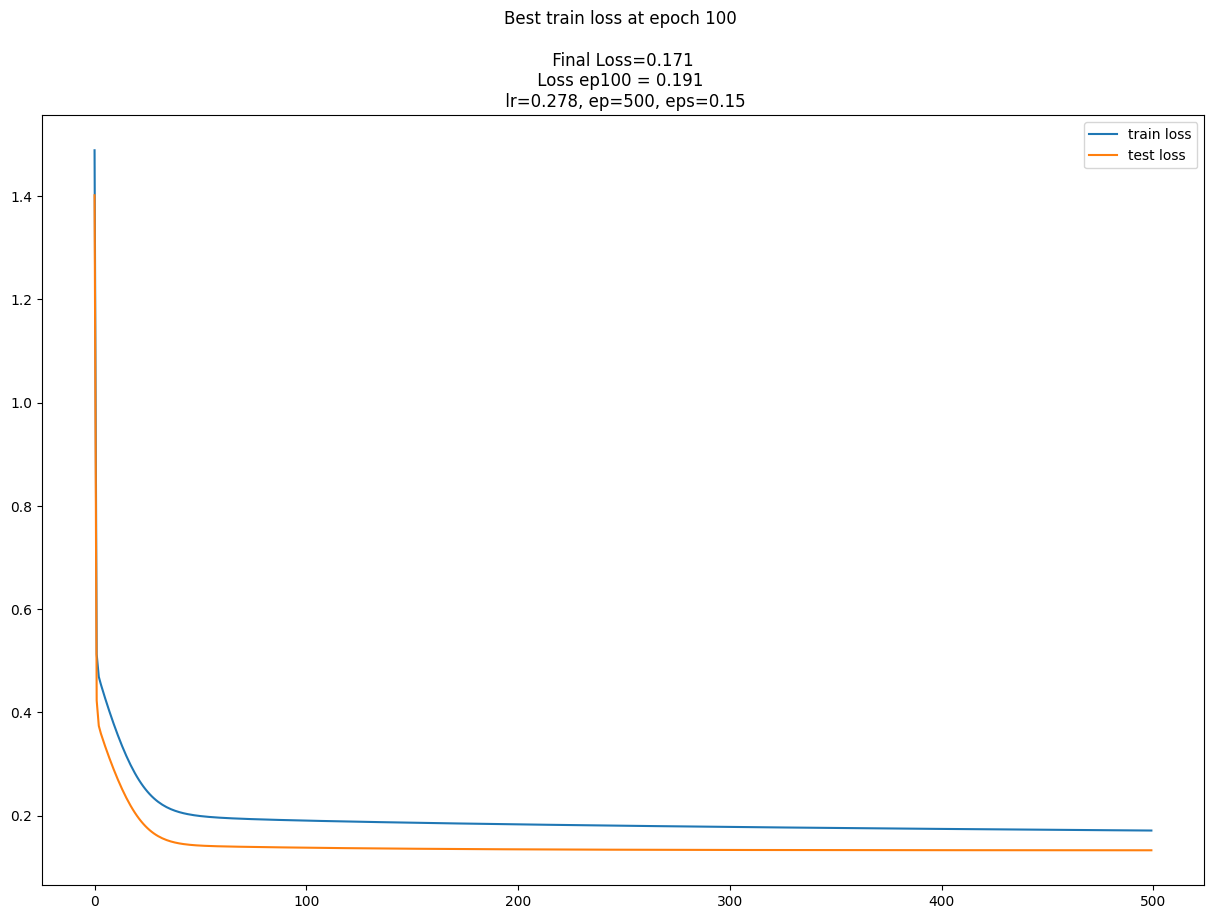

In [152]:
# Min loss for default at epoch 100

(min_lr, min_ep, min_eps), min_train_loss = min(losses['default']['train'].items(), key=lambda x: x[1][100])
min_test_loss = losses['default']['test'][(min_lr, min_ep, min_eps)]

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(min_train_loss, label=f'train loss')
ax.plot(min_test_loss, label=f'test loss')

_ = ax.set_title(f'Best train loss at epoch 100 \n\n Final Loss={min_train_loss[-1].round(3)[0]} \n Loss ep100 = {min_train_loss[100].round(3)[0]}  \n lr={min_lr}, ep={min_ep}, eps={min_eps}')
_ = ax.legend()

# ax.set_ylim(0, 100)

In [109]:
# Filter dropout losses, if any > 800

less_dropout_train_loss = {}
less_dropout_test_loss = {}

for (lr, ep, eps), loss in losses['dropout']['train'].items():
    if any([l > 20 for l in loss]):
        continue
    less_dropout_train_loss[(lr, ep, eps)] = loss
    less_dropout_test_loss[(lr, ep, eps)] = losses['dropout']['test'][(lr, ep, eps)]

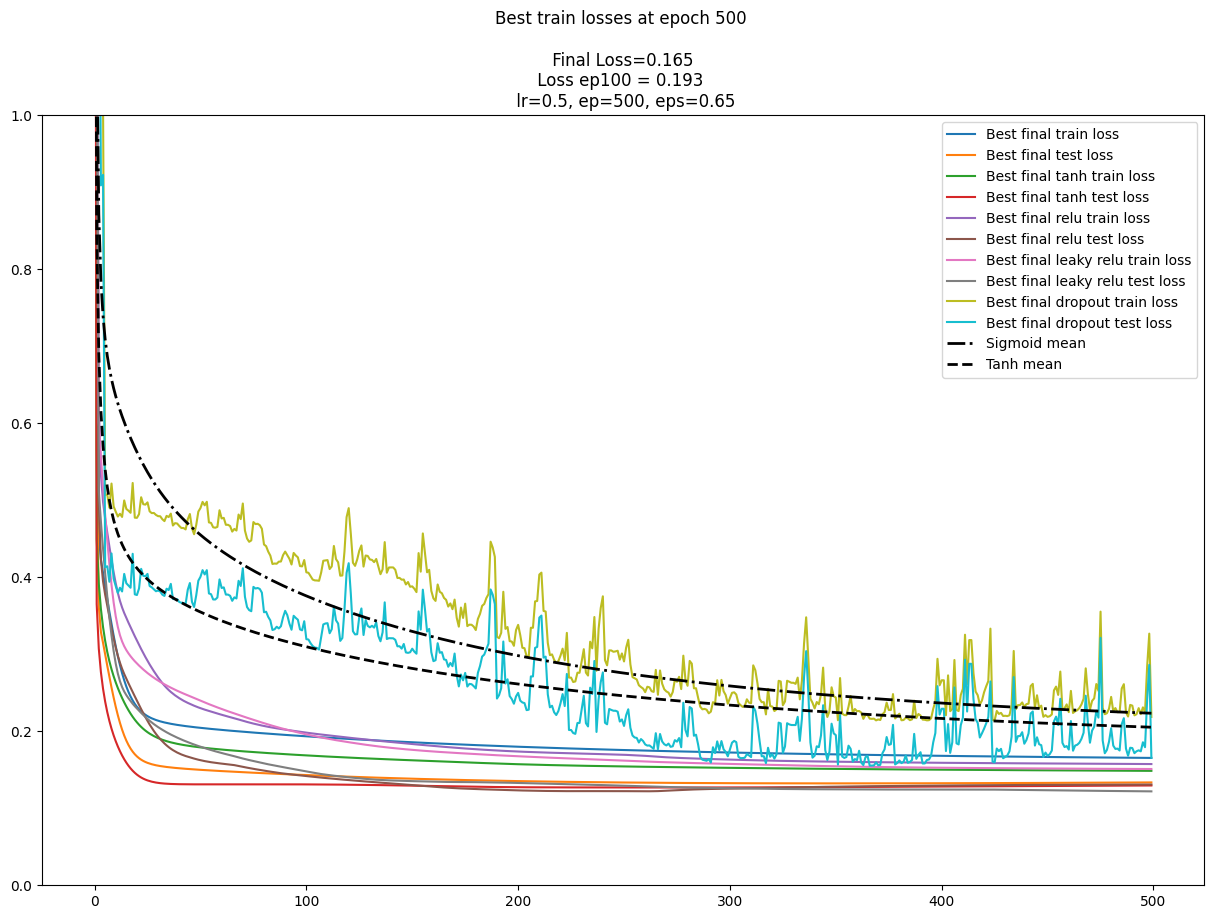

In [185]:
# Min loss for default at epoch 500

(min_lr, min_ep, min_eps), min_train_loss = min(losses['default']['train'].items(), key=lambda x: x[1][-1])
min_test_loss = losses['default']['test'][(min_lr, min_ep, min_eps)]

(min_tanh_lr, min_tanh_ep, min_tanh_eps), min_tanh_train_loss = min(losses['tanh']['train'].items(), key=lambda x: x[1][-1])
min_tanh_test_loss = losses['tanh']['test'][(min_tanh_lr, min_tanh_ep, min_tanh_eps)]

(min_relu_lr, min_relu_ep, min_relu_eps), min_relu_train_loss = min(losses['relu']['train'].items(), key=lambda x: x[1][-1])
min_relu_test_loss = losses['relu']['test'][(min_relu_lr, min_relu_ep, min_relu_eps)]

(min_leaky_relu_lr, min_leaky_relu_ep, min_leaky_relu_eps), min_leaky_relu_train_loss = min(losses['leaky_relu']['train'].items(), key=lambda x: x[1][-1])
min_leaky_relu_test_loss = losses['leaky_relu']['test'][(min_leaky_relu_lr, min_leaky_relu_ep, min_leaky_relu_eps)]

(min_dropout_lr, min_dropout_ep, min_dropout_eps), min_dropout_train_loss = min(less_dropout_train_loss.items(), key=lambda x: x[1][-1])
min_dropout_test_loss = less_dropout_test_loss[(min_dropout_lr, min_dropout_ep, min_dropout_eps)]

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(min_train_loss, label=f'Best final train loss')
ax.plot(min_test_loss, label=f'Best final test loss')

ax.plot(min_tanh_train_loss, label=f'Best final tanh train loss')
ax.plot(min_tanh_test_loss, label=f'Best final tanh test loss')

ax.plot(min_relu_train_loss, label=f'Best final relu train loss')
ax.plot(min_relu_test_loss, label=f'Best final relu test loss')

ax.plot(min_leaky_relu_train_loss, label=f'Best final leaky relu train loss')
ax.plot(min_leaky_relu_test_loss, label=f'Best final leaky relu test loss')

ax.plot(min_dropout_train_loss, label=f'Best final dropout train loss')
ax.plot(min_dropout_test_loss, label=f'Best final dropout test loss')

# add mean lines

ax.plot(np.mean([l for _, l in losses['default']['train'].items()], axis=0), color='black', linestyle='dashdot', linewidth=2, label='Sigmoid mean')
ax.plot(np.mean([l for _, l in losses['tanh']['train'].items()], axis=0), color='black', linestyle='--', linewidth=2, label='Tanh mean')
# ax.plot(np.mean([l for _, l in losses['relu']['train'].items()], axis=0), color='black', linestyle=':', linewidth=2, label='ReLU mean')
# ax.plot(np.mean([l for _, l in losses['leaky_relu']['train'].items()], axis=0), color='black', linestyle='dashdot', linewidth=2, label='Leaky ReLU mean')

_ = ax.set_title(f'Best train losses at epoch 500 \n\n Final Loss={min_train_loss[-1].round(3)[0]} \n Loss ep100 = {min_train_loss[100].round(3)[0]}  \n lr={min_lr}, ep={min_ep}, eps={min_eps}')
_ = ax.set_ylim(0, 1)
_ = ax.legend()

In [186]:
values_df = pd.DataFrame({
    'learning rate': [min_lr, min_tanh_lr, min_dropout_lr, min_relu_lr, min_leaky_relu_lr],
    'epsilon': [min_eps, min_tanh_eps, min_dropout_eps, min_relu_eps, min_leaky_relu_eps],
    'epochs': [min_ep, min_tanh_ep, min_dropout_ep, min_relu_ep, min_leaky_relu_ep],
    'train_loss': [min_train_loss[-1].round(3)[0], min_tanh_train_loss[-1].round(3)[0], min_dropout_train_loss[-1].round(3)[0], min_relu_train_loss[-1].round(3)[0], min_leaky_relu_train_loss[-1].round(3)[0]],
    'test_loss': [min_test_loss[-1].round(3)[0], min_tanh_test_loss[-1].round(3)[0], min_dropout_test_loss[-1].round(3)[0], min_relu_test_loss[-1].round(3)[0], min_leaky_relu_test_loss[-1].round(3)[0]],
    'train_loss_ep100': [min_train_loss[100].round(3)[0], min_tanh_train_loss[100].round(3)[0], min_dropout_train_loss[100].round(3)[0], min_relu_train_loss[100].round(3)[0], min_leaky_relu_train_loss[100].round(3)[0]],
    'test_loss_ep100': [min_test_loss[100].round(3)[0], min_tanh_test_loss[100].round(3)[0], min_dropout_test_loss[100].round(3)[0], min_relu_test_loss[100].round(3)[0], min_leaky_relu_test_loss[100].round(3)[0]],
}, index=['sigmoid', 'tanh', 'dropout', 'relu', 'leaky_relu']).sort_values(by='train_loss')

values_df

learning rate                epsilon  epochs  \
tanh       0.38900000000000001243 0.05000000000000000278     500   
leaky_relu 0.22300000000000000377 0.10000000000000000555     500   
relu       0.27800000000000002487 0.10000000000000000555     500   
sigmoid    0.50000000000000000000 0.65000000000000002220     500   
dropout    0.33400000000000001910 0.65000000000000002220     500   

                       train_loss              test_loss  \
tanh       0.14899999999999999356 0.13000000000000000444   
leaky_relu 0.15099999999999999534 0.12199999999999999734   
relu       0.15700000000000000067 0.13100000000000000533   
sigmoid    0.16500000000000000777 0.13400000000000000799   
dropout    0.21900000000000000022 0.16600000000000000866   

                 train_loss_ep100        test_loss_ep100  
tanh       0.16900000000000001132 0.13100000000000000533  
leaky_relu 0.19600000000000000755 0.14799999999999999267  
relu       0.19800000000000000933 0.14199999999999998734  
sigmoid    0.19300000000000000488 0.14299999999999998823  
dropout    0.40600000000000002753 0.32000000000000000666

Text(0.5, 1.0, 'Best Train and test loss for different activation functions')

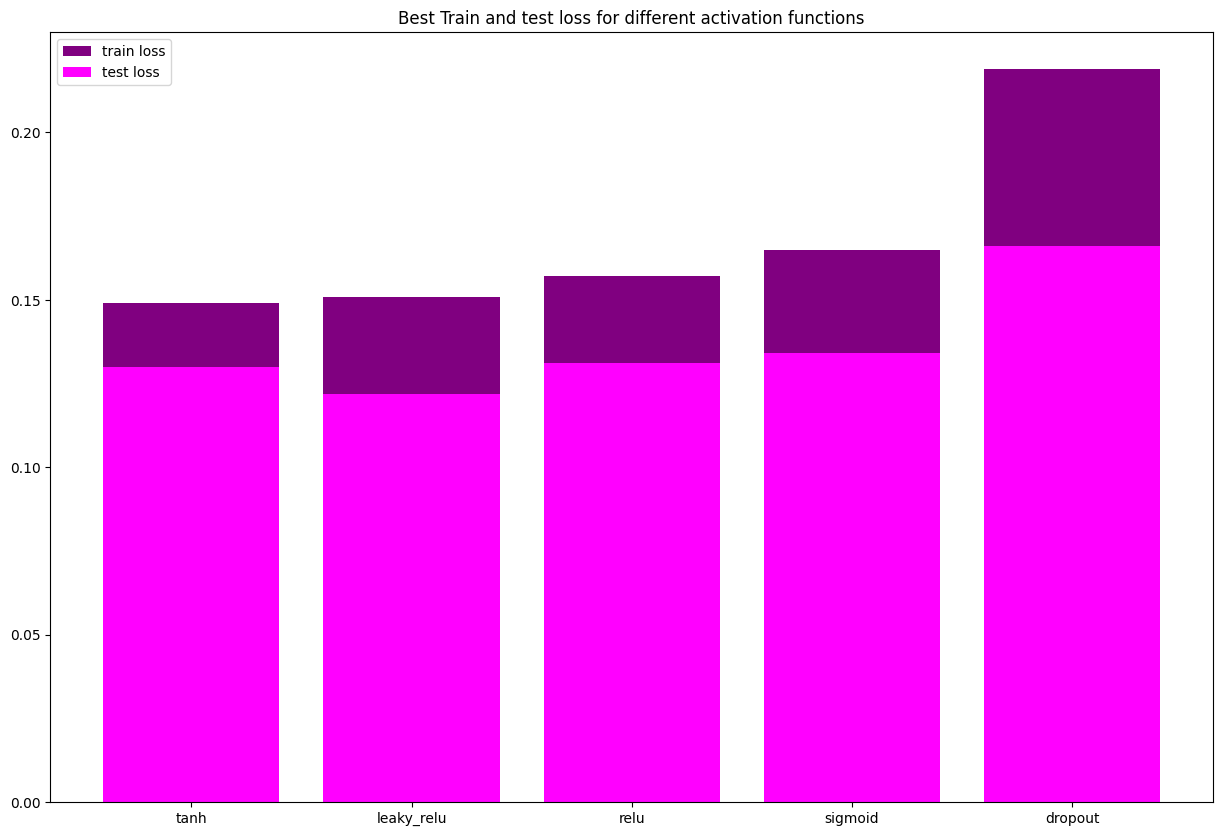

In [190]:
# Bar plot

fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(values_df.index, values_df['train_loss'], label='train loss', color='purple')
ax.bar(values_df.index, values_df['test_loss'], label='test loss', color='magenta')

ax.legend()
ax.set_title('Best Train and test loss for different activation functions')

Podemos observar que la menor loss se obtuvo con la función de activación Tanh.

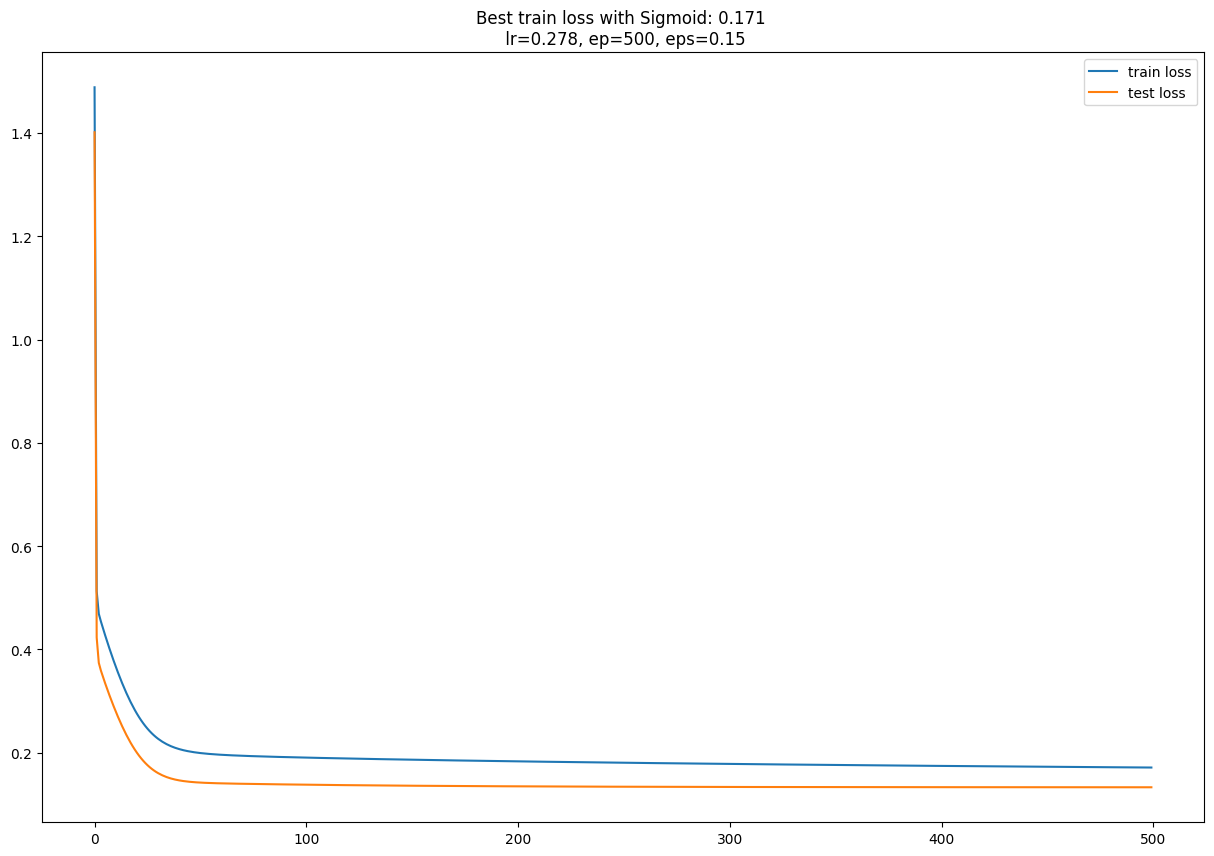

In [167]:
np.random.seed(42)

# Plot Min Train Loss 

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(min_train_loss, label=f'train loss')
ax.plot(min_test_loss, label=f'test loss')
_ = ax.set_title(f'Best train loss with Sigmoid: {min_train_loss[-1].round(3)[0]} \n lr={min_lr}, ep={min_ep}, eps={min_eps}')
_ = ax.legend()
# _ = ax.set_ylim(0, 100)

100%|██████████| 400/400 [00:01<00:00, 215.98it/s]


### Final Loss

0.17904779564689985

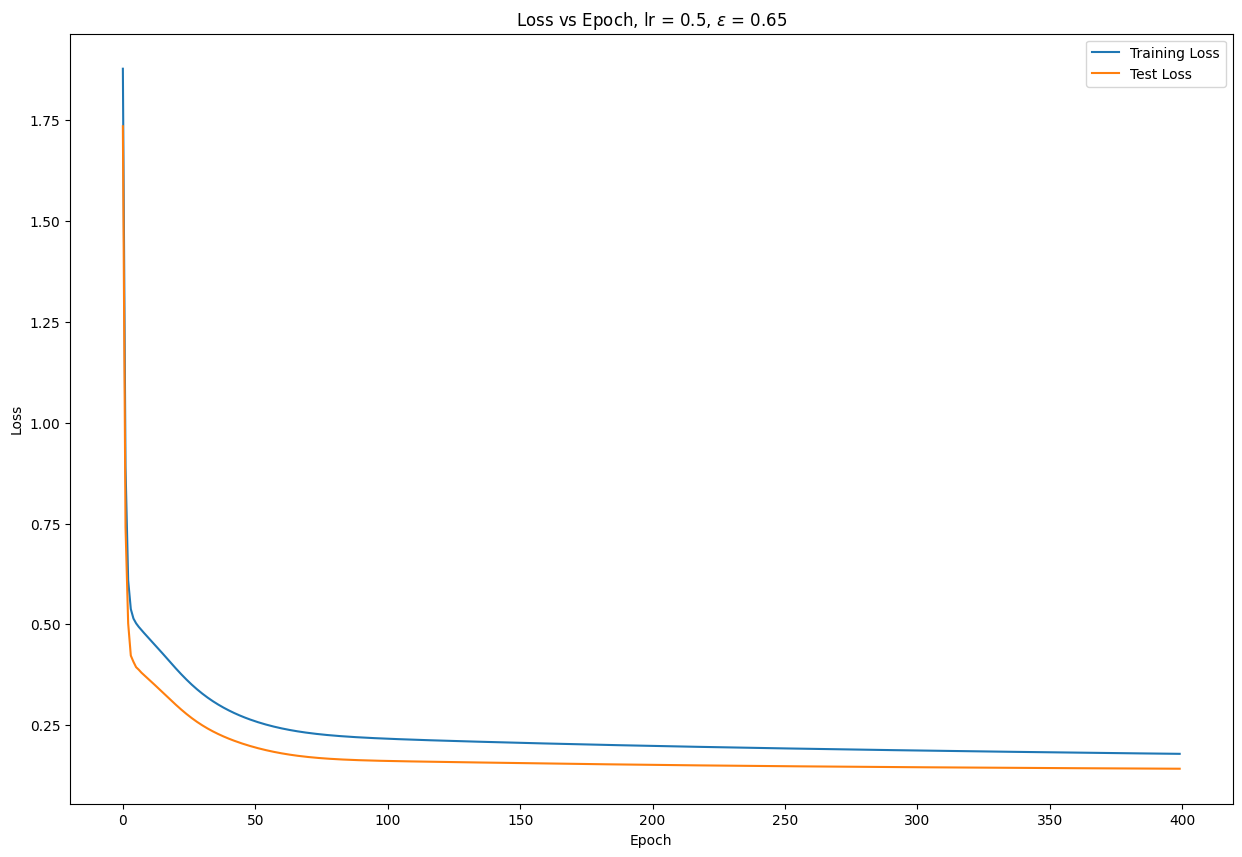

In [191]:
np.random.seed(42)

# set numpy seed

nn_final = NeuralNet()
nn_final.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=400, lr=min_lr, eps=min_eps, verbose=True)

display(Markdown("### Final Loss"))
display(nn_final.get_training_loss()[-1][0])
fig, ax = plt.subplots(figsize=(15, 10))
_ = nn_final.plot_loss(ax=ax)
# ax.set_ylim(0, 100)

Finalmente podemos evaluar el modelo con los mejores parámetros obtenidos sobre el conjunto de test.

In [206]:
y_pred = (nn_final.predict(X_test) * real_estate.std()[-1] + real_estate.mean()[-1]).T[0]
y_pred

array([35.16640765, 46.58375515, 40.27020072, 51.06217802, 31.74673718,
       20.20956558, 41.9791232 , 45.68503091, 46.16453509, 25.85744106,
       41.96381913, 48.21225087, 48.97101351, 30.63376107, 20.52980799,
       17.3182424 , 18.36384378, 35.3128957 , 47.50979686, 39.2879619 ,
       41.24290076, 38.05818244, 36.01876854, 42.34207037, 55.29136454,
       36.48960355, 41.39809753, 49.47216097, 42.73785389, 28.32908788,
       43.46856553, 27.60581665, 20.26637823, 50.79490843, 47.50979686,
       41.67184639, 24.76699714, 19.17173905, 27.96490286, 27.7040609 ,
       53.47655593, 45.64269474, 53.53499719, 51.27813477, 25.92692286,
       43.51485236, 42.83893253, 45.77033436, 48.70610567, 44.37194369,
       21.08991342, 20.37369185, 24.72551919, 44.79443284, 20.86906426,
       44.7494388 , 42.91294312, 40.58747575, 48.93052698, 52.50854914,
       25.26168082, 27.17486278, 49.53834697, 43.63705749, 55.55714971,
       49.2874901 , 51.8155572 , 20.53850622, 37.21328565, 19.87

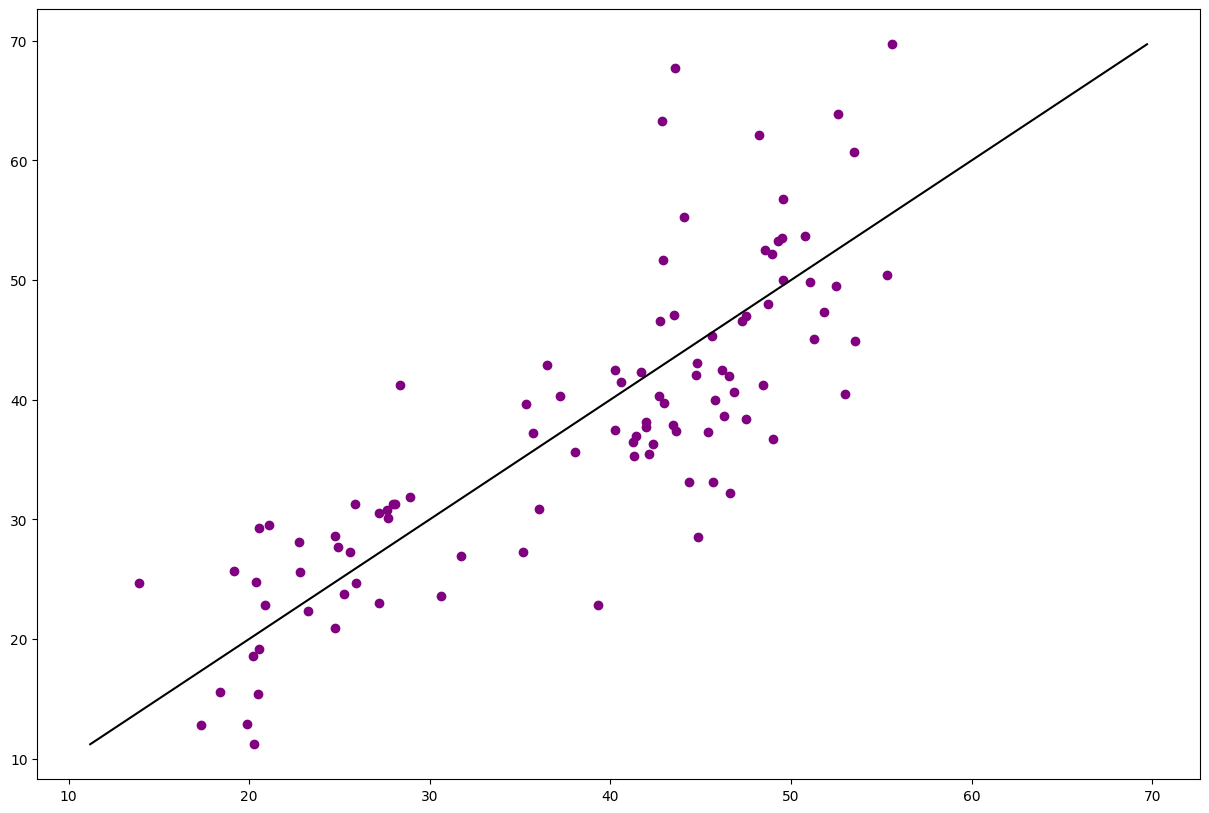

In [210]:
fig, ax = plt.subplots(figsize=(15, 10))

# plot y_pred vs y_test denormalized

y_test_denorm = (y_test * real_estate.std()[-1] + real_estate.mean()[-1]).T[0]

#y_pred in the x axis, y_test in the y axis

ax.scatter(y_pred, y_test_denorm, color='purple', label='Predicted vs Real')

# plot f(x) = x

ax.plot([y_test_denorm.min(), y_test_denorm.max()], [y_test_denorm.min(), y_test_denorm.max()], color='black', label='f(x)=x')

## Conclusiones

En este trabajo práctico pudimos ver como el gradiente descendente nos permite entrenar una red neuronal. Pudimos ver como la función de activación sigmoide es la mas adecuada para este tipo de problemas, y como el learning rate y la cantidad de epochs afectan la convergencia de la red.

También pudimos ver como la mascara de pesos no es una buena opción para este tipo de problemas, ya que no logra converger a una loss minima menor que la obtenida sin aplicar la mascara.